In [2]:
print("hello world")

hello world


In [3]:
import numpy as np
import copy
import json
import math
from glob import glob
import scipy.spatial.distance as sciDist
from tqdm import tqdm
import requests
import time
import itertools
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from itertools import islice
from PIL import Image
import re
from tqdm import tqdm


# Headless simulator version
index = 7 # local server index 
#API_ENDPOINT = 'http://localhost:400' + str(index) + '/simulation' # NOT THE LS VERSION
API_ENDPOINT = 'http://localhost:400' + str(1) + '/simulation' # NOT THE LS VERSION
HEADERS = {"Content-Type": "application/json"}
batchCount = 25 # Send this number of samples to MotionGen each time 
speedscale = 1
steps = 360
minsteps = int(steps*20/360)

# Search for "stephenson" or "watt" in the JSON file and collect their names and indices
json_path = "KV_468_062324.json"
with open(json_path, "r") as f:
    data = json.load(f)

matches = []
for idx, name in enumerate(data):
    lname = name.lower()
    if "step" in lname or "watt" in lname:
        matches.append([name, idx])
print(matches)


# Things for 4 bar 
mechType = index
types = ['RRRR', 'RRRP', 'RRPR', 'PRPR']
for mechanism in matches:
    types.append(mechanism[0])
print(types)
# ['RRRR', 'RRRP', 'RRPR', 'PRPR', 'Watt2T1A1', 'Steph1T3', 'Watt1T1A1', 'Steph3T2A2', 'Watt1T3A2', 'Steph2T2A1', 'Steph3T1A2', 'Watt2T2A2', 'Watt1T2A1', 'Steph2T1A1', 'Steph3T2A1', 'Watt1T1A2', 'Watt2T1A2', 'Steph1T2', 'Steph1T1', 'Watt1T3A1', 'Watt1T2A2', 'Watt2T2A1', 'Steph3T1A1', 'Steph2T1A2', 'Steph2T2A2']

# Create a directory in outputs-6bar for each type in types
'''
for t in types:
    if t in ('RRRR', 'RRRP', 'RRPR', 'PRPR'):
        continue
    dir_path = os.path.abspath("./outputs-6bar/" + t)
    os.makedirs(dir_path, exist_ok=True)'''



typeIndex = [49, 64, 155, 175] # to avoid confusion from any other type
for mechanism in matches:
    typeIndex.append(mechanism[1])

print(typeIndex)
# [49, 64, 155, 175, 0, 2, 19, 26, 37, 39, 73, 82, 90, 110, 111, 125, 133, 135, 137, 139, 149, 163, 169, 176, 177]


#couplerCurveIndex = [4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


#confirm that all c values are 1 at index 7 for 6 bars

bsi = "BSIdict_468_062324_3.json"
with open(bsi, "r") as b:
    data = json.load(b)

num_coord_of_mech = []


for key in types:
    if key in data:
        c_value = (data)[key].get("c")
        print(key, c_value)
        num_coord_of_mech.append(len(c_value))

print(num_coord_of_mech)
# Update couplerCurveIndex so that for each type, its value is the index of the number 1 in the c_value list from BSIdict
couplerCurveIndex = []
for key in types:
    if key in data:
        c_value = data[key].get("c")
        if isinstance(c_value, list) and 1 in c_value:
            couplerCurveIndex.append(c_value.index(1))
        else:
            couplerCurveIndex.append(4)  # fallback default
    else:
        couplerCurveIndex.append(4)      # fallback default
print("Updated couplerCurveIndex:", couplerCurveIndex)
# Updated couplerCurveIndex: [4, 4, 4, 4, 7, 7, 7, 7, 6, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 4, 7, 4]


savePointNumber = [5, 6, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] #len of c arrat acording to BSIdict
needAddtional = [False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] # notice that when true, some of the points can change its position randomly 
#initStates = np.load("./npy-inputs/" + 'RandPos-.npy')

initStates = np.load("/gpfs/scratch/raytang/walking-dataset-generator-old-simulator/Image-method-Synthesis-main/npy-inputs/RandPos-.npy")

errCtr = 0
batch = []
batchSaveStr = []
batchSaveNpyStr = []


# The transformation 
#np.save(saveDir + name + ' ' + types[index], param)
saveDir = os.path.abspath("./outputs-6bar/" + types[index] )
saveDirNpy = os.path.abspath("./outputs-6bar/" + types[index] + "-npy")
print(saveDir, saveDirNpy)



[['Watt2T1A1', 0], ['Steph1T3', 2], ['Watt1T1A1', 19], ['Steph3T2A2', 26], ['Watt1T3A2', 37], ['Steph2T2A1', 39], ['Steph3T1A2', 73], ['Watt2T2A2', 82], ['Watt1T2A1', 90], ['Steph2T1A1', 110], ['Steph3T2A1', 111], ['Watt1T1A2', 125], ['Watt2T1A2', 133], ['Steph1T2', 135], ['Steph1T1', 137], ['Watt1T3A1', 139], ['Watt1T2A2', 149], ['Watt2T2A1', 163], ['Steph3T1A1', 169], ['Steph2T1A2', 176], ['Steph2T2A2', 177]]
['RRRR', 'RRRP', 'RRPR', 'PRPR', 'Watt2T1A1', 'Steph1T3', 'Watt1T1A1', 'Steph3T2A2', 'Watt1T3A2', 'Steph2T2A1', 'Steph3T1A2', 'Watt2T2A2', 'Watt1T2A1', 'Steph2T1A1', 'Steph3T2A1', 'Watt1T1A2', 'Watt2T1A2', 'Steph1T2', 'Steph1T1', 'Watt1T3A1', 'Watt1T2A2', 'Watt2T2A1', 'Steph3T1A1', 'Steph2T1A2', 'Steph2T2A2']
[49, 64, 155, 175, 0, 2, 19, 26, 37, 39, 73, 82, 90, 110, 111, 125, 133, 135, 137, 139, 149, 163, 169, 176, 177]
RRRR [0, 0, 0, 0, 1]
RRRP [0, 0, 0, 0, 1, 0]
RRPR [0, 0, 0, 0, 1, 0, 0]
PRPR [0, 0, 0, 0, 1]
Watt2T1A1 [0, 0, 0, 0, 0, 0, 0, 1]
Steph1T3 [0, 0, 0, 0, 0, 0, 0, 1]

In [4]:
# good old ones 

def isValid(seq):
    if len(seq.shape) == 2:
        isVal = np.var(seq[:,0]) <= 5e-3 and np.var(seq[:,1]) <= 5e-3
    else:
        isVal = len(seq) == 0 or np.var(seq) <= 5e-3

    if isVal:
        return False
    else:
        return True


def get_pca_inclination(qx, qy, ax=None, label=''):
    """ Performs the PCA
        Return transformation matrix
    """
    cx = np.mean(qx)
    cy = np.mean(qy)
    covar_xx = np.sum((qx - cx)*(qx - cx))/len(qx)
    covar_xy = np.sum((qx - cx)*(qy - cy))/len(qx)
    covar_yx = np.sum((qy - cy)*(qx - cx))/len(qx)
    covar_yy = np.sum((qy - cy)*(qy - cy))/len(qx)
    covar = np.array([[covar_xx, covar_xy],[covar_yx, covar_yy]])
    eig_val, eig_vec= np.linalg.eig(covar)

    # Inclination of major principal axis w.r.t. x axis
    if eig_val[0] > eig_val[1]:
        phi= np.arctan2(eig_vec[1,0], eig_vec[0,0])
    else:
        phi= np.arctan2(eig_vec[1,1], eig_vec[0,1])

    return phi


def get_normalize_curve(jd, steps=None, rotations=1, normalize=True, transformParas=None):
    jd = np.array(jd)
    joint_data_n, x_mean, y_mean, denom, phi = [], None, None, None, None
    if isValid(jd):
        if steps:
            sample_indices = np.linspace(0, jd.shape[0]-1, steps, dtype=np.int32)
            jd = jd[sample_indices,:]
        if normalize:
            if not transformParas:
                x_mean = np.mean(jd[:,0], axis=0, keepdims=True)
                y_mean = np.mean(jd[:,1], axis=0, keepdims=True)
            else:
                x_mean, y_mean, denom, phi = transformParas
            jd[:,0] = jd[:,0] - x_mean
            jd[:,1] = jd[:,1] - y_mean

            if not transformParas:
                denom = np.sqrt(np.var(jd[:,0], axis=0, keepdims=True) + np.var(jd[:,1], axis=0, keepdims=True))
                denom = np.expand_dims(denom, axis=1)
            jd = jd / denom
            t = 0
        if not transformParas:
            phi = -get_pca_inclination(jd[:,0], jd[:,1])
        jd[:,0], jd[:, 1] = rotate_curve(jd, phi)
        for tt in range(rotations):
            joint_data_n.append(jd.copy())
            if rotations > 1:
                jd[:,0], jd[:,1] = rotate_curve(jd, t)
                t = 2*np.pi/rotations

    return joint_data_n, x_mean, y_mean, denom, phi


def rotate_curve(cur, theta):
    cpx = cur[:,0]*np.cos(theta) - cur[:,1]*np.sin(theta)
    cpy = cur[:,0]*np.sin(theta) + cur[:,1]*np.cos(theta)
    return cpx, cpy


def digitize_seq(nums, minlim, maxlim, bin_size=64):
    bins = np.linspace(minlim, maxlim, bin_size-1)
    nums_indices = np.digitize(nums, bins)
    return nums_indices


def get_normalize_joint_data_wrt_one_curve(joint_data, ref_ind = 4):
    ''' input s = [num_curves, num_points, 2]
    '''
    joint_data_n = []
    s = np.array(joint_data)
    if isValid(s[ref_ind]):
        x_mean = np.mean(s[ref_ind:ref_ind+1,:,0], axis=1, keepdims=True)
        y_mean = np.mean(s[ref_ind:ref_ind+1,:,1], axis=1, keepdims=True)
        s[:,:,0] = s[:,:,0] - x_mean
        s[:,:,1] = s[:,:,1] - y_mean
        denom = np.sqrt(np.var(s[ref_ind:ref_ind+1,:,0], axis=1, keepdims=True) + np.var(s[ref_ind:ref_ind+1,:,1], axis=1, keepdims=True))
        denom = np.expand_dims(denom, axis=2) #is this scale? 
        s = s / denom
        phi = -get_pca_inclination(s[ref_ind:ref_ind+1,:,0], s[ref_ind:ref_ind+1,:,1])
        for i in range(s.shape[0]):
            s[i,:,0], s[i,:,1] = rotate_curve(s[i], phi)
    else:
        return s, [None, None, None, None], False

    # s has a shape of (j_num, state, dim)
    return s, [x_mean[0][0], y_mean[0][0], denom[0][0][0], phi], True # tx, ty, scaling, rotation angle 


##############################################################################################
# There are some other necessary transformations. (x_mean, y_mean, phi, denom) are from get_normalize_curve. 
##############################################################################################
def get_image_from_point_cloud(points, xylim, im_size, inverted = True, label=None):
    mat = np.zeros((im_size, im_size, 1), dtype=np.uint8)
    x = digitize_seq(points[:,0], -xylim, xylim, im_size)
    if inverted:
        y = digitize_seq(points[:,1]*-1, -xylim, xylim, im_size)
        mat[y, x, 0] = 1
    else:
        y = digitize_seq(points[:,1], -xylim, xylim, im_size)
        mat[x, y, 0] = 1
    return mat


def process_mech_102723(jointData, ref_ind, im_size = 64, xylim = 3.5, inverted = True, swapAxes = True):
    paras = None

    # It is possible the jointData format is (angles, joint, (x, y)). 
    # You should put a True if this happens. (This is how files are saved).
    # I literally don't understand why I saved jointData with a shape of (angles, joint, (x, y)) 
    if swapAxes:
        jointData = np.swapaxes(jointData, 0, 1)

    # This converts all 
    jointData, paras, success = get_normalize_joint_data_wrt_one_curve(jointData, ref_ind= ref_ind)

    # jointData format from now on becomes np.array with a shape of (joint, curve_length, dimension)
    jointData = np.array(jointData)

    if success:
        # get binaryImage 
        jd = jointData[ref_ind]
        mat = get_image_from_point_cloud(jd, xylim=xylim, im_size=im_size, inverted=inverted)
        return mat, paras, success
    else: 
        return None, None, success


def calc_dist(coord):
    # Calculate differences using broadcasting
    diffs = coord[:, np.newaxis, :] - coord[np.newaxis, :, :]
    squared_dists = np.sum(diffs ** 2, axis=2)

    # Extract the upper triangle indices where i < j
    i, j = np.triu_indices(len(coord), k=1)
    dist_arr = np.sqrt(squared_dists[i, j])
    dist_arr = dist_arr/min(dist_arr)
    return np.round(dist_arr, 2)

In [5]:
############################################################################################## 
# An even better version of normalization method (it can be slower sometimes)
# Uses reflection correction (contributed by the paper Geometric Invariant Curve and Surface Normalization)  
# Thanks to Zhijie who noticed these two can be used together. 
##############################################################################################

def rotate_curve(curve, phi):
    infunction_scale = 100
    # curve is scaled 100 times for numerical accuracy 
    # incoming curve shape: (n,2)
    x = curve[:, 0] * infunction_scale
    y = curve[:, 1] * infunction_scale
    # Compute the rotated coordinates
    x_rotated = x * np.cos(phi) - y * np.sin(phi)
    y_rotated = x * np.sin(phi) + y * np.cos(phi)
    # Combine the rotated coordinates into a new curve
    rotated_curve = np.column_stack((x_rotated, y_rotated))
    return rotated_curve/infunction_scale


def center_data(X):
    """ Center the data by subtracting the mean of each column.
        Return the translated X and the translation matrix 
    """
    m = np.mean(X, axis=0) # (n, 2)
    return X - m, np.matrix([[1, 0, -m[0]], [0, 1, -m[1]], [0, 0, 1]]) # equal to XP this is a translation matrix tranposed  


def scale_data(X, scaling = 0): 
    """ Scale the data according to two different metrics 
        If scaling == 0 (default), scaling method is normalization (average distance 1)
        If otherwise, scaling method is standardization to a certain scale 
        Return the scaled X, and the scaling matrix. 
    """
    if scaling == 0:
        # use variance. 
        denom = np.sqrt(np.var(X[:,0]) + np.var(X[:,1]))
        scaled_curve = X /denom
        ScaleMat = np.matrix([[1/denom, 0, 0], [0, 1/denom, 0], [0, 0, 1]])
    else:
        # Compute the maximum distance from the origin 
        max_distance = np.max(np.linalg.norm(X, axis=1))
        scaled_curve = X * scaling / max_distance
        ScaleMat = np.matrix([[scaling/max_distance, 0, 0], [0, scaling/max_distance, 0], [0, 0, 1]])
    return scaled_curve, ScaleMat


def rotate_data(X, tol = 1e-4, randinit = False): 
    """ Performs the PCA and determines rotation angle phi 
        More precisely it is snapping the greatest principal axis to the X-axis. 
        Return the rotated X and the rotation matrix 
    """
    phiInit = 0
    if randinit:
        phiInit = np.random.rand() * math.pi * 2 

    rotationMatInit = np.matrix([
        [np.cos(phiInit), -np.sin(phiInit), 0], 
        [np.sin(phiInit), np.cos(phiInit), 0],
        [0, 0, 1] 
    ])

    X0 = rotate_curve(X, phiInit)
    cx = np.mean(X0[:,0])
    cy = np.mean(X0[:,1])
    covar_xx = np.sum((X0[:,0] - cx)*(X0[:,0] - cx))/X0.shape[0]
    covar_xy = np.sum((X0[:,0] - cx)*(X0[:,1] - cy))/X0.shape[0]
    covar_yx = np.sum((X0[:,1] - cy)*(X0[:,0] - cx))/X0.shape[0]
    covar_yy = np.sum((X0[:,1] - cy)*(X0[:,1] - cy))/X0.shape[0]
    covar = np.array([[covar_xx, covar_xy],[covar_yx, covar_yy]])

    if np.abs(np.linalg.det(covar)) < tol:
        phi = 0 # why rotate anyway? 
    else:
        eig_val, eig_vec= np.linalg.eig(covar) 
        # Inclination of major principal axis w.r.t. x axis
        # Enforcing the cross-product of the two eigenvectors to be greater than 0. 
        # Not necessary, but it looks clean to do so. 
        # Eigenvector matrix: [a, b], det = crossproduct of b x a
        if np.linalg.det(eig_vec) > 0:
            eig_vec[0,:] = -eig_vec[0,:] # enforcing a x b > 0 
        if eig_val[0] > eig_val[1]:
            phi= np.arctan2(eig_vec[1,0], eig_vec[0,0])
        else:
            phi= np.arctan2(eig_vec[1,1], eig_vec[0,1])
    rotated_curve = rotate_curve(X0, phi)
    rotationMat = np.matrix([
        [np.cos(phi), -np.sin(phi), 0], 
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1] 
    ])

    return rotated_curve, np.matmul(rotationMat, rotationMatInit)


def reflect_data(X):
    """ Computes the third order moment and determines the reflections 
        The data must be rotated before this step. 

    """
    # Reflection normalization 
    x_scaled = X[:, 0]
    y_scaled = X[:, 1]

    # see paper Geometric Invariant Curve and Surface Normalization
    # compute the 3rd-order moments 
    m12 = np.sum((x_scaled**1)*(y_scaled**2))
    m21 = np.sum((x_scaled**2)*(y_scaled**1))
    signm12 = np.sign(m12)
    signm21 = np.sign(m21)
    if np.abs(signm12) < 1e-5:
        signm12 = 1
    if np.abs(signm21) < 1e-5:
        signm21 = 1

    reflectionMat = np.array(
        [[signm12, 0],
         [0, signm21]]
    ) 

    if np.abs(m12) > np.abs(m21):
        reflectionMat = np.matmul(np.array([[0,1],[1,0]]), reflectionMat)

    reflected_Curve = np.matmul(reflectionMat, np.array(X).T).T
    reflectionMat = np.matrix(
        [[reflectionMat[0,0], reflectionMat[0,1], 0], 
         [reflectionMat[1,0], reflectionMat[1,1], 0], 
         [0, 0, 1]
        ]
    ) 

    return reflected_Curve, reflectionMat


# Digitization 
def digitize_seq(nums, minlim, maxlim, bin_size=64):
    bins = np.linspace(minlim, maxlim, bin_size-1)
    nums_indices = np.digitize(nums, bins)
    return nums_indices


def get_image_from_point_cloud(points, xylim, im_size, inverted = True, label=None):
    mat = np.zeros((im_size, im_size, 1), dtype=np.uint8)
    x = digitize_seq(points[:,0], -xylim, xylim, im_size)
    if inverted:
        y = digitize_seq(points[:,1]*-1, -xylim, xylim, im_size)
        mat[y, x, 0] = 1
    else:
        y = digitize_seq(points[:,1], -xylim, xylim, im_size)
        mat[x, y, 0] = 1
    return mat


# Returns normalized curve, Transformation matrix, and Success (if determinant is greater than tolerance for numerical stability)
def normalize_data_122223(X, scaling = 0, tol = 1e-8, maxiter = 2):
    X1, M1 = center_data(X) 
    X1, M2 = scale_data(X1, scaling = scaling)
    X1, M3 = rotate_data(X1)
    X1, M4 = reflect_data(X1)
    M = M4*M3*M2*M1 # This is the transformation matrix 

    detVal = np.abs(np.linalg.det(M))
    if detVal*scaling < tol:
        for i in range(maxiter):
            X1, M1 = center_data(X1)
            X1, M2 = scale_data(X1, scaling = scaling)
            X1, M3 = rotate_data(X1, randinit= True)
            X1, M4 = reflect_data(X1)
            if np.abs(np.linalg.det(M)) > tol or detVal*10 < np.abs(np.linalg.det(M)):
                break
    return X1, M4*M3*M2*M1, np.abs(np.linalg.det(M)) > tol


def matmul_jd(jd, mat):
    # input should be (..., ,2)
    # the operation: 
    jd = np.array(jd)
    oldshape = jd.shape
    njd= np.reshape(jd, (-1, 2))
    hc1= np.ones((njd.shape[0], 1))
    njd=np.matrix(np.concatenate([njd, hc1], axis = 1)).transpose()
    njd=np.array((mat*njd).transpose())[:,0:2].reshape(oldshape)
    return njd


# Processing 
# THIS IS THE MAIN FUNCTION YOU NEED (second version) 
# Input is the mechanism and coupler point index (ref_ind), Output is matImg, [<two transformation matrix instead of six parameters>], and Success. 
# NOTICE 1: the parameter has SIX parameters, not four (x, y translation, angle and scale). The addtional parameters are reflectionMat, seqReversed (refrlection matrix and whether or not the sequence is reverse in order)
# NOTICE 2: the transformation matrices are numpy arrays. You need to convert them to lists before converting them into .json format objects. 
# I suggest you save the a, b, c, d, e, f values in the matrix. 
# A transformation matrix is shaped as: 
# [[a, c, e]
#  [b, d, f]
#  [0, 0, 1]]
def process_mech_051524(jointData, ref_ind, im_size = 64, xylim = 3.5, inverted = True):
    # New JD shape is always (states, joints, dimensions)
    paras = None
    # get matrices according to curve. 
    nc, mat, success = normalize_data_122223(jointData[:,ref_ind,:], scaling = 3.5)
    NR_MG = mat # transform original position to normalized position # NR_MG * jointData = normalized joint data
    MG_NR = np.linalg.inv(NR_MG) 

    if success:
        # get binaryImage # rohit's choice on what to save 
        paras = NR_MG
        matImg = get_image_from_point_cloud(nc, xylim=xylim, im_size=im_size, inverted=inverted)
        return matImg, paras, success
    else: 
        return None, None, success

    
def calc_dist(coord):
    # Calculate differences using broadcasting
    diffs = coord[:, np.newaxis, :] - coord[np.newaxis, :, :]
    squared_dists = np.sum(diffs ** 2, axis=2)

    # Extract the upper triangle indices where i < j
    i, j = np.triu_indices(len(coord), k=1)
    dist_arr = np.sqrt(squared_dists[i, j])
    dist_arr = dist_arr/min(dist_arr)
    return np.round(dist_arr, 2)

In [6]:
def format_floats_to_string(float_list):
    formatted_strings = [f"{value:.3f}" for value in float_list]
    result_string = ' '.join(formatted_strings)
    return ' ' + result_string

# Example usage
float_values = [3920, -1.000e-03, 5.393e+00, 1.748e+00, -8.786e+00, 2.079e+00, 5.023e+00, -4.854e+00, 4.230e-01, 5.406e+00, -1.882e+00, -1.388e+00, 0.241, -0.285, 0.455, 0.899, 0.0, 1.0]

formatted_string = format_floats_to_string(float_values)
print(formatted_string)



 3920.000 -0.001 5.393 1.748 -8.786 2.079 5.023 -4.854 0.423 5.406 -1.882 -1.388 0.241 -0.285 0.455 0.899 0.000 1.000


22
[-0.829  3.646  1.272  4.249  9.755 -4.85  -8.97   5.657 -9.065 -2.444
 -2.236 -4.902 -2.275  8.091]
[[-0.829  3.646]
 [ 1.272  4.249]
 [ 9.755 -4.85 ]
 [-8.97   5.657]
 [-9.065 -2.444]
 [-2.236 -4.902]
 [-2.275  8.091]]
{'type': 'Steph3T1A1', 'params': [[-0.829, 3.646], [1.272, 4.249], [9.755, -4.85], [-8.97, 5.657], [-9.065, -2.444], [-2.236, -4.902], [-2.275, 8.091]], 'speedScale': 1.0, 'steps': 360, 'relativeTolerance': 0.1}
plot calculted
plot saved to /gpfs/scratch/raytang/debug_plot_1762375471.png


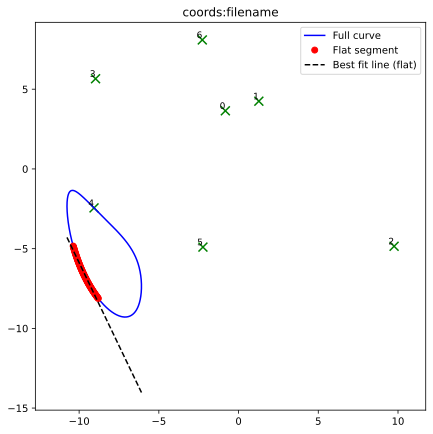

plot shown
P:[[[-0.829       3.646     ]
  [ 1.272       4.249     ]
  [ 9.755      -4.85      ]
  ...
  [-9.065      -2.444     ]
  [-2.236      -4.902     ]
  [-2.275       8.091     ]]

 [[-0.829       3.646     ]
  [ 1.26438176  4.27469602]
  [ 9.755      -4.85      ]
  ...
  [-9.03798315 -2.4709984 ]
  [-2.2164395  -4.90190298]
  [-2.275       8.091     ]]

 [[-0.829       3.646     ]
  [ 1.2565056   4.30031311]
  [ 9.755      -4.85      ]
  ...
  [-9.01096583 -2.49799633]
  [-2.196879   -4.90180597]
  [-2.275       8.091     ]]

 ...

 [[-0.829       3.646     ]
  [ 1.29537577  4.16028287]
  [ 9.755      -4.85      ]
  ...
  [-9.15649865 -2.35259449]
  [-2.3261777  -4.90193954]
  [-2.275       8.091     ]]

 [[-0.829       3.646     ]
  [ 1.28892063  4.18629442]
  [ 9.755      -4.85      ]
  ...
  [-9.12947301 -2.3795841 ]
  [-2.30661704 -4.90199624]
  [-2.275       8.091     ]]

 [[-0.829       3.646     ]
  [ 1.28220381  4.21224065]
  [ 9.755      -4.85      ]
  ...
  [-9.10245

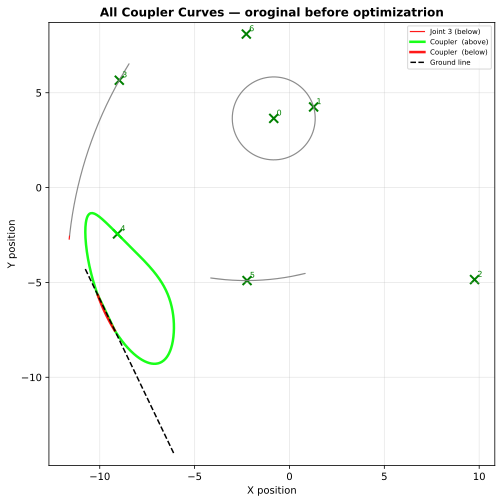

✅ Saved diagnostic plot: /gpfs/scratch/raytang/all_coupler_curves_oroginal before optimizatrion.jpg
(512, 2)
Optimization done. Best offsets: [ 0.69278823  0.01453366 -0.26237778 -0.5202764 ]
[-0.829       3.646       1.272       4.249       9.755      -4.85
 -8.27721177  5.67153366 -9.32737778 -2.9642764  -2.236      -4.902
 -2.275       8.091     ]
adjustedf params: [[-0.829       3.646     ]
 [ 1.272       4.249     ]
 [ 9.755      -4.85      ]
 [-8.27721177  5.67153366]
 [-9.32737778 -2.9642764 ]
 [-2.236      -4.902     ]
 [-2.275       8.091     ]]
{'type': 'Steph3T1A1', 'params': [[-0.829, 3.646], [1.272, 4.249], [9.755, -4.85], [-8.277211766247195, 5.67153365547074], [-9.327377780548396, -2.9642764038604996], [-2.236, -4.902], [-2.275, 8.091]], 'speedScale': 1.0, 'steps': 512, 'relativeTolerance': 0.1}
optimized path:
[[[-0.829       3.646     ]
  [ 1.272       4.249     ]
  [ 9.755      -4.85      ]
  ...
  [-9.32737778 -2.9642764 ]
  [-2.236      -4.902     ]
  [-2.275       

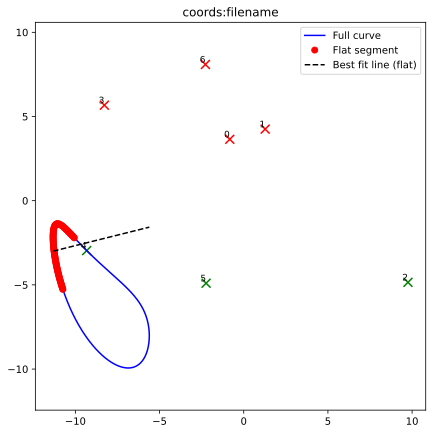

plot shown


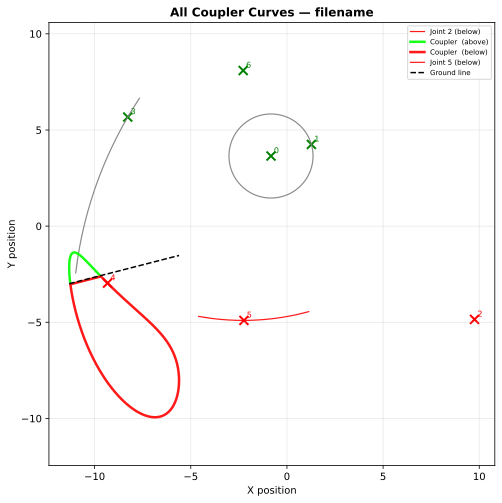

✅ Saved diagnostic plot: /gpfs/scratch/raytang/all_coupler_curves_filename.jpg


array([[[-0.829     ,  3.646     ],
        [ 1.272     ,  4.249     ],
        [ 9.755     , -4.85      ],
        ...,
        [-9.32737778, -2.9642764 ],
        [-2.236     , -4.902     ],
        [-2.275     ,  8.091     ]],

       [[-0.829     ,  3.646     ],
        [ 1.26115621,  4.28557567],
        [ 9.755     , -4.85      ],
        ...,
        [-9.28754254, -3.00393149],
        [-2.20558584, -4.90184183],
        [-2.275     ,  8.091     ]],

       [[-0.829     ,  3.646     ],
        [ 1.24967573,  4.32195651],
        [ 9.755     , -4.85      ],
        ...,
        [-9.24762421, -3.0435029 ],
        [-2.1751718 , -4.90166747],
        [-2.275     ,  8.091     ]],

       ...,

       [[-0.829     ,  3.646     ],
        [-2.94047646,  4.21122311],
        [ 9.755     , -4.85      ],
        ...,
        [-5.61913131, -8.2906615 ],
        [ 0.70298518, -4.55617517],
        [-2.275     ,  8.091     ]],

       [[-0.829     ,  3.646     ],
        [-2.95001937,  4.17

In [7]:
import multiprocessing as mp
from functools import partial
import os
import numpy as np
import requests
import json
import time
import re
from tqdm import tqdm
from PIL import Image
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import LineString
%matplotlib inline
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
#matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Your existing functions remain unchanged
def has_sharp_edges(coords, curvature_threshold=15.0, smoothing_sigma=1.0):
    if smoothing_sigma > 0:
        x = gaussian_filter1d(coords[:,0], sigma=smoothing_sigma)
        y = gaussian_filter1d(coords[:,1], sigma=smoothing_sigma)
    else:
        x = coords[:,0]
        y = coords[:,1]

    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return np.any(curvature > curvature_threshold), curvature

def resample_uniform(points, M):
    dif = np.diff(points, axis=0)
    seglen = np.sqrt((dif**2).sum(axis=1))
    s = np.concatenate(([0], np.cumsum(seglen)))
    total = s[-1]
    if total == 0:
        return np.repeat(points[:1], M, axis=0)
    s_uniform = np.linspace(0, total, M)
    x = np.interp(s_uniform, s, points[:,0])
    y = np.interp(s_uniform, s, points[:,1])
    return np.column_stack((x, y))

import numpy as np
from scipy.interpolate import interp1d

def resample_uniform_tensor(P, N_resample=512):
    """
    Resample the entire P tensor (T, J, 2) uniformly along each joint's trajectory.
    
    Args:
        P (np.ndarray): original tensor of shape (T, J, 2)
        N_resample (int): number of uniform samples to produce along each joint's path
        
    Returns:
        P_resampled (np.ndarray): resampled tensor of shape (N_resample, J, 2)
    """
    if not isinstance(P, np.ndarray):
        P = np.array(P, dtype=float)
    if P.ndim != 3 or P.shape[2] != 2:
        raise ValueError("P must be a 3D array of shape (T, J, 2)")
    
    T, J, _ = P.shape
    P_resampled = np.zeros((N_resample, J, 2))
    
    for j in range(J):
        # original trajectory for joint j
        path = P[:, j, :]  # (T, 2)
        
        # compute cumulative arc length
        diffs = np.diff(path, axis=0)
        dists = np.sqrt((diffs**2).sum(axis=1))
        s = np.concatenate(([0], np.cumsum(dists)))
        
        if s[-1] == 0:  # degenerate path (joint never moved)
            P_resampled[:, j, :] = path[0]
            continue
        
        # normalize to [0, 1]
        s_norm = s / s[-1]
        s_new = np.linspace(0, 1, N_resample)
        
        # interpolate x and y along the normalized arc-length
        fx = interp1d(s_norm, path[:, 0], kind='linear', bounds_error=False, fill_value="extrapolate")
        fy = interp1d(s_norm, path[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")
        
        P_resampled[:, j, 0] = fx(s_new)
        P_resampled[:, j, 1] = fy(s_new)
    
    return P_resampled


def pca_align(points):
    pts = points - np.mean(points, axis=0)
    U, S, VT = np.linalg.svd(pts, full_matrices=False)
    pcs = VT.T
    rotated = pts @ pcs
    return rotated, pcs
'''


def detect_flat_via_pca(points, K_keep=12, N_resample=512, eps_slope=0.0075, min_fraction=1/4):
    pts = resample_uniform(points, N_resample)
    rotated, pcs = pca_align(pts)
    dy = np.gradient(rotated[:,1])
    flat_mask = np.abs(dy) < eps_slope
    
    from itertools import groupby
    runs = [sum(1 for _ in g) for val,g in groupby(flat_mask) if val]
    max_run = max(runs) if runs else 0
    flat_fraction = max_run / len(flat_mask)
    is_flat_enough = flat_fraction >= min_fraction
    
    first_pc = pcs[:,0]
    angle = np.arctan2(first_pc[1], first_pc[0])

    max_run = 0
    run_indices = []
    current_run = []

    for i, is_flat in enumerate(flat_mask):
        if is_flat:
            current_run.append(i)
            if len(current_run) > max_run:
                max_run = len(current_run)
                run_indices = current_run.copy()
        else:
            current_run = []

    return {
        'flat_fraction': float(flat_fraction),
        'is_flat_enough': bool(is_flat_enough),
        'orientation_rad': float(angle),
        'orientation_deg': float(np.degrees(angle)),
        'max_run': int(max_run),
        'N': int(len(flat_mask)),
        'flat_indices': np.array(run_indices, dtype=int), 
        'pts': pts,
    }

def ground_clearance_check(path_coords, joint_coords, flat_indices):
    if len(flat_indices) == 0:
        return False
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)

    d_path = path_coords[:,1] - (m*path_coords[:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = joint_coords[:,1] - (m*joint_coords[:,0] + b)
    all_clear = np.all(np.sign(d_joints) == majority_sign)
    return all_clear'''

def plot_flat_fit_with_joints(path_coords, flat_indices, joint_coords, save_dir, filename):
    if len(flat_indices) == 0:
        return
    
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)
    x_line = np.linspace(path_coords[:,0].min(), path_coords[:,0].max(), 200)
    y_line = m * x_line + b

    d_path = path_coords[:,1] - (m*path_coords[:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = joint_coords[:,1] - (m*joint_coords[:,0] + b)

    plt.figure(figsize=(7,7))
    plt.plot(path_coords[:,0], path_coords[:,1], 'b-', label='Full curve')
    plt.plot(flat_pts[:,0], flat_pts[:,1], 'ro', label='Flat segment')
    plt.plot(x_line, y_line, 'k--', label='Best fit line (flat)')

    for i, (x, y) in enumerate(joint_coords):
        if np.sign(d_joints[i]) == majority_sign:
            plt.scatter(x, y, c='g', marker='x', s=80)
        else:
            plt.scatter(x, y, c='r', marker='x', s=80)
        plt.text(x, y, str(i), fontsize=9, ha='right', va='bottom')



    plt.axis('equal')
    plt.legend()
    plt.title(f"coords:{filename}")
    print("plot calculted")
    out_path = os.path.join(save_dir, f"debug_plot_{int(time.time())}.png")
    plt.savefig(out_path, dpi=300)
    print(f"plot saved to {out_path}")


    plt.show()
    print("plot shown")
    plt.close()


def save_flat_fit_with_joints(path_coords, flat_indices, joint_coords, save_dir, filename):
    if len(flat_indices) == 0:
        return
    
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)
    x_line = np.linspace(path_coords[:,0].min(), path_coords[:,0].max(), 200)
    y_line = m * x_line + b

    d_path = path_coords[:,1] - (m*path_coords[:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = joint_coords[:,1] - (m*joint_coords[:,0] + b)

    plt.figure(figsize=(7,7))
    plt.plot(path_coords[:,0], path_coords[:,1], 'b-', label='Full curve')
    plt.plot(flat_pts[:,0], flat_pts[:,1], 'ro', label='Flat segment')
    plt.plot(x_line, y_line, 'k--', label='Best fit line (flat)')

    for i, (x, y) in enumerate(joint_coords):
        if np.sign(d_joints[i]) == majority_sign:
            plt.scatter(x, y, c='g', marker='x', s=80)
        else:
            plt.scatter(x, y, c='r', marker='x', s=80)
        plt.text(x, y, str(i), fontsize=9, ha='right', va='bottom')

    plt.axis('equal')
    plt.legend()
    plt.title(f"coords:{filename}")

    os.makedirs(save_dir, exist_ok=True)
    filename = f"{filename}.jpg"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, format='jpg')
    plt.close()

def plot_all_coupler_curves(P_opt, flat_indices, joint_coords, save_dir, filename, mechType):
    """
    Plots all joint trajectories (coupler curves) and highlights:
      - red segments below the ground line,
      - green segments above the ground line,
      - coupler joint in bold green,
      - joint coords as X marks (green if above, red if below).
    """
    num_joints = num_coord_of_mech[mechType]
    coupler_index = couplerCurveIndex[mechType]

    if len(flat_indices) == 0:
        print("⚠️ No flat indices found, skipping plot.")
        return

    # --- Compute ground line using flat indices ---
    flat_pts = resample_uniform(P_opt[flat_indices, coupler_index, :], 512)
    m, b = np.polyfit(flat_pts[:, 0], flat_pts[:, 1], 1)
    x_line = np.linspace(P_opt[:, coupler_index, 0].min(), P_opt[:, coupler_index, 0].max(), 200)
    y_line = m * x_line + b

    plt.figure(figsize=(8, 8))

    # --- Plot trajectories for all joints ---
    for j in range(num_joints):
        X = P_opt[:, j, 0]
        Y = P_opt[:, j, 1]
        Y_ground = m * X + b

        # Split curve into above/below ground
        above = Y >= Y_ground
        below = ~above

        # Plot above and below sections separately
        for seg_type, mask, color in [('above', above, 'gray'), ('below', below, 'red')]:
            if np.any(mask):
                plt.plot(
                    X[mask],
                    Y[mask],
                    color=color if j != coupler_index else ('lime' if seg_type == 'above' else 'red'),
                    lw=2.5 if j == coupler_index else 1.2,
                    alpha=0.9,
                    label=f"{'Coupler ' if j == coupler_index else 'Joint ' + str(j)} ({seg_type})" if j == coupler_index or seg_type == 'below' else None
                )

    # --- Plot the ground line ---
    plt.plot(x_line, y_line, 'k--', lw=1.5, label='Ground line')

    # --- Plot joint coords with color-coded X markers ---
    for j, (x, y) in enumerate(joint_coords):
        y_ground = m * x + b
        color = 'green' if y >= y_ground else 'red'
        plt.scatter(x, y, color=color, marker='x', s=80, lw=2)
        plt.text(x + 0.15, y + 0.15, f"{j}", fontsize=8, color=color, weight='normal')

    # --- Final layout ---
    plt.axis('equal')
    plt.title(f"All Coupler Curves — {filename}", fontsize=12, weight='bold')
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.legend(fontsize=7, loc='best')
    plt.grid(alpha=0.3)

    # --- Save and show ---
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, f"all_coupler_curves_{filename}.jpg")
    plt.savefig(filepath, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✅ Saved diagnostic plot: {filepath}")



def has_self_intersections(coords):
    line = LineString(coords)
    return not line.is_simple

def is_closed(pts):
    start_pt = pts[0]
    end_pt = pts[-1]
    path_dist = np.linalg.norm(end_pt - start_pt)
    is_closed = path_dist < 0.1
    return is_closed

def str_to_coords(s):
    s = str(s)
    nums = [float(x) for x in s.strip().split()]
    return [[nums[j], nums[j+1]] for j in range(0, len(nums), 2)]



    
import os, json, time, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize
import requests

# ============================================================
# 1️⃣ Helper: Extract params + mechType from filename
# ============================================================

def extract_params_from_filename(filename, mechTypeIndex, num_coords_in_mech):
    """
    Extracts numeric parameters from a filename like:
    walking_plot_1.23_-4.52_2.35_0.0_5.25.jpg or similar.
    Returns np.ndarray of floats.
    """
    basename = os.path.basename(filename)
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", basename)
    return np.array([float(x) for x in nums][:(num_coords_in_mech[mechTypeIndex])*2])

def get_mechtype_from_path(filepath, types):
    """
    Extracts the mechanism type (e.g., 'Steph3T1A1') from a full file path and 
    returns both the name and its index in the types list.
    """
    import os

    # Split into components
    parts = filepath.split('/')

    mechType = None
    for part in parts:
        if part.startswith("walking_plot_"):
            mechType = part.replace("walking_plot_", "").strip()
            break

    if mechType is None:
        raise ValueError(f"Could not find mechanism type in path: {filepath}")

    # Find index in the types list
    try:
        mechTypeIndex = types.index(mechType)
    except ValueError:
        raise ValueError(f"Mechanism type '{mechType}' not found in types list: {types}")

    return mechType, mechTypeIndex



# ============================================================
# 2️⃣ Helper: Compute ground line (slope m, intercept b)
# ============================================================
def orient_ground_line(path_coords, flat_indices):
    """
    Compute the ground line (m, b) for the flat segment,
    and flip it if the majority of the path lies below it.
    Ensures ground line is always the *lowest* flat side.
    """
    if len(flat_indices) == 0:
        raise ValueError("No flat indices found.")

    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:, 0], flat_pts[:, 1], 1)

    # Calculate signed distance from each path point to line
    d = path_coords[:, 1] - (m * path_coords[:, 0] + b)
    avg_dist = np.mean(d)

    # If most points lie BELOW the flat line → flip the line vertically
    if avg_dist < 0:
        m = -m
        b = -b
        path_coords[:, 1] = -path_coords[:, 1]  # reflect vertically
        print("⚙️ Ground orientation flipped (path was upside down).")

    return m, b, path_coords


def compute_ground_line(path_coords, flat_indices):
    if len(flat_indices) == 0:
        raise ValueError("No flat indices found.")
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)
    return m, b


# ============================================================
# 3️⃣ Detect joints whose paths go below the ground
# ============================================================

def find_joints_below_ground(P, joint_coords, m, b, tol=1e-9):
    below_indices = []
    for j in range(P.shape[1]):
        y_line = m * P[:, j, 0] + b
        if np.any(P[:, j, 1] < y_line - tol):  # <- tolerance to ignore noise
            below_indices.append(j)
    return below_indices



# ============================================================
# 4️⃣ Error function for optimization
# ============================================================

def error(phi, param, joints_to_adjust, mechType, coupler_index, original_curve, m, b):
    """
    Optimization error: sum of intersection + shape deviation.
    Only adjusts the joints listed in joints_to_adjust.
    """
    # Copy parameters
    adjusted_param = np.copy(param)
    for i, j_idx in enumerate(joints_to_adjust):
        adjusted_param[2*j_idx] += phi[2*i]     # X offset
        adjusted_param[2*j_idx + 1] += phi[2*i+1]  # Y offset

    # Re-run simulator with adjusted params
    exampleData = {
        'type': types[mechType],
        'params': adjusted_param.tolist(),
        'speedScale': 1.0,
        'steps': 512,
        'relativeTolerance': 0.1
    }

    try:
        response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
        P_adj = np.array(response[0]['poses'])
    except Exception:
        return 1e9  # large penalty if fails

    # Intersection penalty: any joint path below ground
    y_line = m * P_adj[:, :, 0] + b
    below = np.minimum(P_adj[:, :, 1] - y_line, 0)
    intersection_penalty = np.sum(below**2)

    # Coupler shape difference penalty
    diff = P_adj[:, coupler_index, :] - original_curve
    shape_penalty = np.sum(diff**2)

    total_error = intersection_penalty + 0.1 * shape_penalty
    return total_error


# -------------------------------------------------------------------------------------------------------------------------------------



'''def detect_flat_via_pca(points, K_keep=12, N_resample=512, eps_slope=0.0075, min_fraction=1/4):
    """
    Improved flat detection:
      - resamples uniformly to N_resample
      - computes rotated coordinates via PCA
      - finds all contiguous 'flat' runs where abs(dy) < eps_slope
      - selects the run whose mean rotated[:,1] is largest (the 'top' flat segment)
        -- this uses the assumption you described: joints start on the top side
      - returns the usual fields plus:
         - 'selected_flat_indices' : indices of the chosen flat run (in resampled pts)
         - 'rotated_pts' : pts in PCA-rotated frame
    """
    pts = resample_uniform(points, N_resample)
    rotated, pcs = pca_align(pts)
    dy = np.gradient(rotated[:, 1])
    flat_mask = np.abs(dy) < eps_slope

    # find contiguous runs of True in flat_mask; store their index arrays
    from itertools import groupby
    runs = []
    current = []
    for i, val in enumerate(flat_mask):
        if val:
            current.append(i)
        else:
            if current:
                runs.append(np.array(current, dtype=int))
                current = []
    if current:
        runs.append(np.array(current, dtype=int))

    # compute flat_fraction using the longest run as before
    max_run = max((len(r) for r in runs), default=0)
    flat_fraction = max_run / len(flat_mask)
    is_flat_enough = flat_fraction >= min_fraction

    # Choose "topmost" run: the run with the largest mean rotated[:,1]
    selected_flat_indices = np.array([], dtype=int)
    if runs:
        best_run = None
        best_run_mean = -np.inf
        for r in runs:
            mean_y = rotated[r, 1].mean()
            if mean_y > best_run_mean:
                best_run_mean = mean_y
                best_run = r
        selected_flat_indices = best_run.copy() if best_run is not None else np.array([], dtype=int)

    first_pc = pcs[:, 0]
    angle = np.arctan2(first_pc[1], first_pc[0])

    return {
        'flat_fraction': float(flat_fraction),
        'is_flat_enough': bool(is_flat_enough),
        'orientation_rad': float(angle),
        'orientation_deg': float(np.degrees(angle)),
        'max_run': int(max_run),
        'N': int(len(flat_mask)),
        'flat_indices_all': runs,                    # list of arrays (all runs)
        'selected_flat_indices': selected_flat_indices,
        'pts': pts,
        'rotated_pts': rotated,
        'pcs': pcs
    }'''




def detect_flat_via_pca(points, K_keep=12, N_resample=512, eps_slope=0.0075, min_fraction=1/4):
    pts = resample_uniform(points, N_resample)
    rotated, pcs = pca_align(pts)
    dy = np.gradient(rotated[:,1])
    flat_mask = np.abs(dy) < eps_slope
    
    from itertools import groupby
    runs = [sum(1 for _ in g) for val,g in groupby(flat_mask) if val]
    max_run = max(runs) if runs else 0
    flat_fraction = max_run / len(flat_mask)
    is_flat_enough = flat_fraction >= min_fraction
    
    first_pc = pcs[:,0]
    angle = np.arctan2(first_pc[1], first_pc[0])

    max_run = 0
    run_indices = []
    current_run = []

    for i, is_flat in enumerate(flat_mask):
        if is_flat:
            current_run.append(i)
            if len(current_run) > max_run:
                max_run = len(current_run)
                run_indices = current_run.copy()
        else:
            current_run = []

    return {
        'flat_fraction': float(flat_fraction),
        'is_flat_enough': bool(is_flat_enough),
        'orientation_rad': float(angle),
        'orientation_deg': float(np.degrees(angle)),
        'max_run': int(max_run),
        'N': int(len(flat_mask)),
        'flat_indices': np.array(run_indices, dtype=int), 
        'pts': pts,
    }


def compute_ground_line_with_sign(path_coords, flat_indices, joint_coords=None):
    """
    Fit the ground line to path_coords[flat_indices] and determine the 'majority_sign'.
    majority_sign = +1 means joints should be above the line (y - (m x + b) > 0).
    majority_sign = -1 means joints should be below the line.
    If joint_coords provided, majority_sign is computed using joint_coords; otherwise uses
    the coupler curve point distribution (fallback).
    Returns (m, b, majority_sign).
    """
    if len(flat_indices) == 0:
        raise ValueError("No flat indices provided to compute ground line.")

    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:, 0], flat_pts[:, 1], 1)

    # compute signed distances for joint positions if available
    if joint_coords is not None and len(joint_coords) > 0:
        d_joints = joint_coords[:, 1] - (m * joint_coords[:, 0] + b)
        # majority sign is the sign where most joints are located
        s = np.sign(d_joints)
        # if some zeros (exact on line), treat them as positive (arbitrary)
        s[s == 0] = 1
        majority_sign = int(np.sign(np.sum(s)))
        if majority_sign == 0:
            majority_sign = 1
    else:
        # fallback: look at coupler curve points (use mean sign)
        d_path = path_coords[:, 1] - (m * path_coords[:, 0] + b)
        s = np.sign(np.sum(d_path))
        majority_sign = int(s) if s != 0 else 1

    return float(m), float(b), int(majority_sign)


def ground_clearance_check_v2(path_coords, joint_coords, flat_indices):
    """
    Same idea as original ground_clearance_check but uses compute_ground_line_with_sign
    and enforces that sign of joints must equal majority_sign.
    Returns True if all joints are on the majority side (no joint crosses to other side).
    """
    if len(flat_indices) == 0:
        return False
    m, b, majority_sign = compute_ground_line_with_sign(path_coords, flat_indices, joint_coords)
    d_joints = joint_coords[:, 1] - (m * joint_coords[:, 0] + b)
    s = np.sign(d_joints)
    s[s == 0] = majority_sign  # consider exact-on-line as correct side
    all_clear = np.all(s == majority_sign)
    return bool(all_clear)


def find_joints_below_ground_v2(P, joint_coords, m, b, majority_sign):
    """
    Returns indices of joints whose *paths* have any points on the wrong side of the ground line.
    Uses majority_sign to interpret which side is 'up'.
      - If majority_sign == +1: joints should have y - (m x + b) > 0. We flag any point where y_line_diff < 0.
      - If majority_sign == -1: reverse sign test.
    Input P is shape (T, J, 2).
    """
    below_indices = []
    # compute signed distance of every point to the line for all joints: shape (T, J)
    x = P[:, :, 0]
    y = P[:, :, 1]
    y_line = m * x + b
    signed = y - y_line  # positive values are 'above' line
    if majority_sign == 1:
        # we want signed > 0 always; flagged if any signed < 0
        for j in range(P.shape[1]):
            if np.any(signed[:, j] < 0):
                below_indices.append(j)
    else:
        # majority_sign == -1: we want signed < 0 always
        for j in range(P.shape[1]):
            if np.any(signed[:, j] > 0):
                below_indices.append(j)
    return below_indices


def error_geom(phi, param, joints_to_adjust, mech_index, coupler_index, original_curve, m, b):
    """
    Geometry-only error:
      - penalize any joint path crossing the ground line (big penalty)
      - penalize if optimized mechanism no longer qualifies as walking (missing flat, not closed, sharp edges, self-intersect)
    phi: flattened offsets for only joints_to_adjust [dx1, dy1, dx2, dy2, ...]
    param: original param (1D array of floats length 2*num_joints OR flattened list)
    mech_index: mechanism index into your `types` & coupler index arrays.
    coupler_index: index of the coupler joint in the P matrix (0-based)
    original_curve: original coupler curve (T,2) from initial sim
    m, b: ground line fitted to the selected flat run
    """
    # construct adjusted parameter vector
    adjusted_param = np.array(param, dtype=float).copy()
    # param might be flattened or nested 2xN; ensure flattened
    adjusted_param = adjusted_param.flatten()

    for i, j_idx in enumerate(joints_to_adjust):
        adjusted_param[2 * j_idx] += float(phi[2 * i])
        adjusted_param[2 * j_idx + 1] += float(phi[2 * i + 1])

    # POST to simulator (same shape expected: list with one example)
    exampleData = {
        'type': types[mech_index],
        'params': adjusted_param.tolist(),
        'speedScale': 1.0,
        'steps': 512,
        'relativeTolerance': 0.1
    }

    try:
        resp = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData]), timeout=30)
        resp.raise_for_status()
        response = resp.json()
        if not response or not isinstance(response, list) or len(response) == 0:
            return 1e9
        P_adj = np.array(response[0]['poses'])  # shape (T, J, 2)
    except Exception:
        # heavy penalty on simulator failure
        return 1e9

    # 1) intersection penalty: sum of squared depth of any points on wrong side
    x = P_adj[:, :, 0]; y = P_adj[:, :, 1]
    y_line = m * x + b
    signed = y - y_line  # positive = above
    # determine current majority sign using initial joint positions (we can reuse original majority sign decision using joint start positions)
    # but here we prefer to use same majority_sign as earlier: compute sign of the first frame joints
    majority_sign = int(np.sign(np.sum((P_adj[0, :, 1] - (m * P_adj[0, :, 0] + b)))))
    if majority_sign == 0:
        majority_sign = 1
    if majority_sign == 1:
        below = np.minimum(signed, 0.0)   # negative -> below, penalty is squared depth
    else:
        below = np.maximum(signed, 0.0)   # positive -> below for reversed orientation
    intersection_penalty = np.sum(below**2)

    # 2) walking-qualification penalty: we require that the adjusted coupler path still satisfies the filters
    coupler = P_adj[:, coupler_index, :]
    # a) detect flat via pca: use detect_flat_via_pca on coupler (resampled already by your sim steps)
    pca_out = detect_flat_via_pca(coupler)
    # b) sharp edges check (use your has_sharp_edges)
    sharp, _ = has_sharp_edges(coupler, curvature_threshold=150.0)
    closed_ok = is_closed(coupler)
    self_inter = has_self_intersections(resample_uniform(coupler, 512))

    walk_penalty = 0.0
    if not pca_out['is_flat_enough']:
        walk_penalty += 1e4
    if not closed_ok:
        walk_penalty += 1e4
    if sharp:
        walk_penalty += 1e4
    if self_inter:
        walk_penalty += 1e4

    # Total error: intersection is primary, walking qualifier huge penalty if violated
    total_error = intersection_penalty + walk_penalty
    return float(total_error)


# ============================================================
# 5️⃣ Visualization helper
# ============================================================

def plot_comparison(P_original, P_opt, flat_indices, m, b, coupler_index, save_path=None):
    plt.figure(figsize=(7,7))
    
    # Original
    plt.plot(P_original[:, coupler_index, 0], P_original[:, coupler_index, 1],
             'b-', label='Original Coupler Path')
    # Adjusted
    plt.plot(P_opt[:, coupler_index, 0], P_opt[:, coupler_index, 1],
             'g-', label='Optimized Coupler Path')
    
    # Ground line
    x_line = np.linspace(min(P_original[:, coupler_index, 0].min(), P_opt[:, coupler_index, 0].min()),
                         max(P_original[:, coupler_index, 0].max(), P_opt[:, coupler_index, 0].max()), 200)
    y_line = m * x_line + b
    plt.plot(x_line, y_line, 'k--', label='Ground line')

    plt.axis('equal')
    plt.legend()
    plt.title("Original vs Optimized")
    plt.show()
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300)
    plt.show()


# ============================================================
# 6️⃣ Main test logic (run on one mechanism)
# ============================================================

def optimize_mechanism(file_path):
    
    mechType = get_mechtype_from_path(file_path, types)[1]
    print(mechType)
    param = extract_params_from_filename(file_path, mechType, num_coord_of_mech)
    print(param)
    coupler_index = couplerCurveIndex[mechType]

    params = np.array(param)
    if params.ndim == 1 and len(params) % 2 == 0:
        params = params.reshape(-1, 2)  # convert [x1,y1,x2,y2,...] → [[x1,y1],[x2,y2],...]
        print(params)
    
    # Run initial simulation
    exampleData = {
        'type': types[mechType],
        'params': params.tolist(),
        'speedScale': 1.0,
        'steps': 360,
        'relativeTolerance': 0.1
    }
    print(exampleData)
    #response = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
    
    


    
    #print(json.dumps([exampleData], indent=2))

    response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()

    #print("STATUS:", resp.status_code)
    #print("TEXT:", resp.text[:500])  # print first 500 chars to avoid overload
    
    #print(response)
    
    P = resample_uniform_tensor(np.array(response[0]['poses']))
    joint_coords = P[0, :, :]  # initial positions

    # Find ground line
    '''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_output['flat_indices']
    m, b = compute_ground_line(P[:, coupler_index, :], flat_indices)'''

    '''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_output['flat_indices']
    m, b, P[:, coupler_index, :] = orient_ground_line(P[:, coupler_index, :], flat_indices)'''

    pca_out = detect_flat_via_pca(resample_uniform(P[:, coupler_index, :], 512))
    flat_indices = pca_out['flat_indices']
    m, b, majority_sign = compute_ground_line_with_sign(resample_uniform(P[:, coupler_index, :], 512), flat_indices, joint_coords=joint_coords)

    _, _, P[:, coupler_index, :]  = orient_ground_line(P[:, coupler_index, :], flat_indices)




    # Find joints that go below
    # with resapmle uniform its in the right place now but still shorter
    plot_flat_fit_with_joints(resample_uniform(P[:, coupler_index, :], 512), flat_indices, joint_coords, "/gpfs/scratch/raytang", "filename")
    print(f"P:{P}")
    print(f"joint coords: {joint_coords}")
    joints_to_adjust = find_joints_below_ground_v2(P, joint_coords, m, b, majority_sign)
    #joints_to_adjust[0] -= 1
    print(f"Adjusting joints: {joints_to_adjust}")

    if not joints_to_adjust:
        print("No joints below ground. Skipping optimization.")
        return P
    print("original mech before optimization:")
    plot_all_coupler_curves(P, flat_indices, joint_coords, "/gpfs/scratch/raytang", "oroginal before optimizatrion", mechType)

    # Run optimization only on those joints
    #first do global optyimization
    print(P[:, coupler_index, :].shape)
    bounds = [(-1, 1)] * (2 * len(joints_to_adjust))
    res_global = differential_evolution(
        lambda phi: error(phi, param, joints_to_adjust, mechType, coupler_index, P[:, coupler_index, :], m, b),
        bounds,
        maxiter=300,
        tol=1e-6,
        polish=False,
    )

    best_phi = res_global.x
    print("Optimization done. Best offsets:", best_phi)

    

    # Final recompute
    adjusted_param = np.copy(param)
    for i, j_idx in enumerate(joints_to_adjust):
        adjusted_param[2*j_idx] += best_phi[2*i]
        adjusted_param[2*j_idx + 1] += best_phi[2*i+1]

    print(adjusted_param)


    
    #convert to 2d array
    adjusted_params = np.array(adjusted_param)
    if adjusted_params.ndim == 1 and len(adjusted_params) % 2 == 0:
        adjusted_params = adjusted_params.reshape(-1, 2)  # convert [x1,y1,x2,y2,...] → [[x1,y1],[x2,y2],...]
        print(f"adjustedf params: {adjusted_params}")

    exampleData = {
        'type': types[mechType],
        'params': adjusted_params.tolist(),
        'speedScale': 1.0,
        'steps': 512,
        'relativeTolerance': 0.1
    }

    print(exampleData)
    final_response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
    P_opt = resample_uniform_tensor(np.array(final_response[0]['poses']))
    #_, _, P_opt[:, coupler_index, :] = orient_ground_line(P_opt[:, coupler_index, :], flat_indices)


    # Plot comparison
    #print("aljuygfhearlyjughbaksy,ejurhgjkserg it did it")
    #plot_comparison(P, P_opt, flat_indices, m, b, coupler_index)
    print("optimized path:")
    print(P_opt)
    print("adjsuted:")
    print(adjusted_params)
    try:
        plot_flat_fit_with_joints(P_opt[:, coupler_index, :], flat_indices, adjusted_params, "/gpfs/scratch/raytang", "filename")
        plot_all_coupler_curves(P_opt, flat_indices, adjusted_params, "/gpfs/scratch/raytang", "filename", mechType)

    except Exception:
        pass

    
        
    return P_opt

#optimize_mechanism('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt1T3A1/-0.79 -9.357 -3.938 -8.494 -7.38 -0.255 7.689 5.162 1.801 -8.136 -8.767 4.194 7.248 -5.179  0.084 0.69 1.139 -0.69 0.084 5.56 0. 0. 1. .jpg')

optimize_mechanism('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.829 3.646 1.272 4.249 9.755 -4.85 -8.97 5.657 -9.065 -2.444 -2.236 -4.902 -2.275 8.091  0.315 -0.642 -1.057 -0.642 -0.315 -6.866 0. 0. 1. .jpg')

#optimize_mechanism('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt2T1A2/-1.249 5.499 0.067 2.233 4.155 -7.848 -5.844 -3.409 8.449 1.232 -5.059 0.406 8.301 5.866 -8.159 4.364 0.523 0.548 2.411 0.548 -0.523 7.383 0. 0. 1. .jpg')



In [8]:
print(normFailCtr) # basically not too many steps is the reason. 
print(P.shape)

NameError: name 'normFailCtr' is not defined


=== Checking mechanism orientation for walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.79 1.528 -2.844 1.051 -8.384 4.37 9.604 0.657 2.232 7.152 6.368 -8.867 -4.417 -8.232 0. 0. 1. .jpg ===
Simulating mechanism for orientation check...
Avg start y = -0.334, flat_y_mean = 9.662
Mechanism is upside down — flipping coordinates...
✅ Flipped mechanism path generated.
[[-0.79   1.528]
 [-2.844  1.051]
 [-8.384  4.37 ]
 [ 9.604  0.657]
 [ 2.232  7.152]
 [ 6.368 -8.867]
 [-4.417 -8.232]]
[[-0.79  -1.528]
 [-2.844 -1.051]
 [-8.384 -4.37 ]
 [ 9.604 -0.657]
 [ 2.232 -7.152]
 [ 6.368  8.867]
 [-4.417  8.232]]
walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.790 -1.528 -2.844 -1.051 -8.384 -4.370 9.604 -0.657 2.232 -7.152 6.368 8.867 -4.417 8.232.jpg
22
[-0.79  -1.528 -2.844 -1.051 -8.384 -4.37   9.604 -0.657  2.232 -7.152
  6.368  8.867 -4.417  8.2

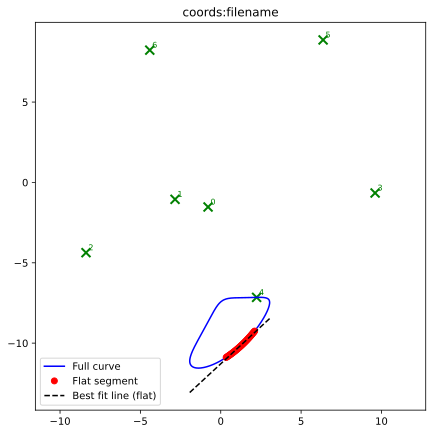

plot shown
P:[[[ -0.79        -1.528     ]
  [ -2.844       -1.051     ]
  [ -8.384       -4.37      ]
  ...
  [  2.232       -7.152     ]
  [  6.368        8.867     ]
  [ -4.417        8.232     ]]

 [[ -0.79        -1.528     ]
  [ -2.85201196  -1.08691989]
  [ -8.384       -4.37      ]
  ...
  [  2.27772952  -7.15101406]
  [  6.3658763    8.9020795 ]
  [ -4.417        8.232     ]]

 [[ -0.79        -1.528     ]
  [ -2.85939582  -1.12297414]
  [ -8.384       -4.37      ]
  ...
  [  2.32346262  -7.15021383]
  [  6.36363984   8.93715199]
  [ -4.417        8.232     ]]

 ...

 [[ -0.79        -1.528     ]
  [  0.72494847  -2.99475701]
  [ -8.384       -4.37      ]
  ...
  [ -1.7837073  -10.54986531]
  [  5.63142348   4.26355603]
  [ -4.417        8.232     ]]

 [[ -0.79        -1.528     ]
  [  0.75031618  -2.96809412]
  [ -8.384       -4.37      ]
  ...
  [ -1.76572308 -10.50780948]
  [  5.64428142   4.29626314]
  [ -4.417        8.232     ]]

 [[ -0.79        -1.528     ]
  [  0.7752

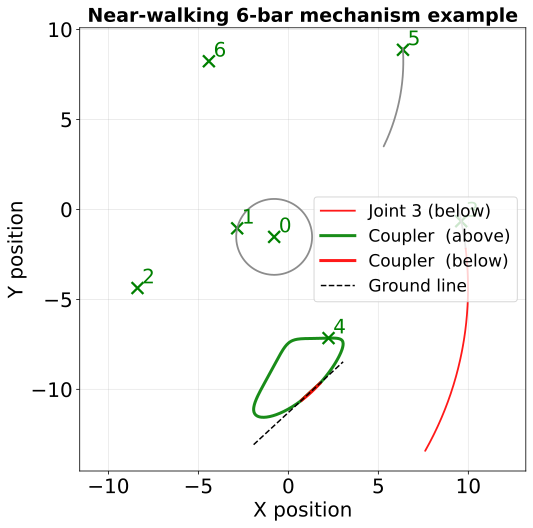

✅ Saved diagnostic plot: /gpfs/scratch/raytang/all_coupler_curves_oroginal before optimizatrion.jpg
🎯 Starting optimization with 2 joints to adjust
🎯 Joints to adjust: [3, 4]
🎯 Bounds: [(-6, 6), (-6, 6), (-6, 6), (-6, 6)]
🔍 error_geom called with phi: [0. 0. 0. 0.]
🔧 mechType index: 22
📍 Coupler index: 4
📊 Initial 2D params shape: (7, 2)
🎯 Joints to adjust: [3, 4]
  Adjusting joint 3 -> 2D index [3, :]
  Adjusting joint 4 -> 2D index [4, :]
📐 Adjusted 2D params: [[-0.79  -1.528]
 [-2.844 -1.051]
 [-8.384 -4.37 ]
 [ 9.604 -0.657]
 [ 2.232 -7.152]
 [ 6.368  8.867]
 [-4.417  8.232]]
📐 Flat params for API: [-0.79, -1.528, -2.844, -1.051, -8.384, -4.37, 9.604, -0.657, 2.232, -7.152, 6.368, 8.867, -4.417, 8.232]
🌐 Sending request to API...
✅ Got P_adj with shape: (512, 7, 2)
pathdist:4.440892098500626e-16
length below: 34.85756562336734, length penalty: 12150498811873.61, pathdist:4.440892098500626e-16, closure_penalty:0.0, intersection_penalty:200000000.0, total error:12150698821873.61
🎯 Te

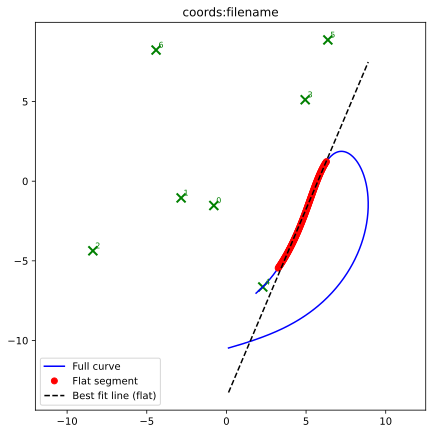

plot shown


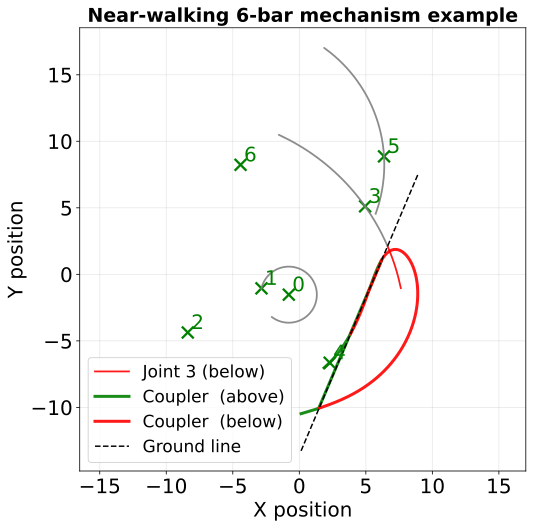

✅ Saved diagnostic plot: /gpfs/scratch/raytang/all_coupler_curves_filename.jpg


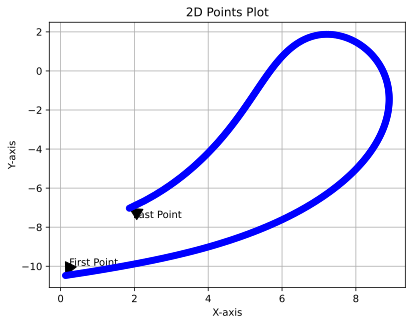

In [40]:
import multiprocessing as mp
from functools import partial
import os
import numpy as np
import requests
import json
import time
import re
from tqdm import tqdm
from PIL import Image
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import LineString
%matplotlib inline
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import functools

print = functools.partial(print, flush=True)  # Force flush after every print

#matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Your existing functions remain unchanged
def has_sharp_edges(coords, curvature_threshold=15.0, smoothing_sigma=1.0):
    if smoothing_sigma > 0:
        x = gaussian_filter1d(coords[:,0], sigma=smoothing_sigma)
        y = gaussian_filter1d(coords[:,1], sigma=smoothing_sigma)
    else:
        x = coords[:,0]
        y = coords[:,1]

    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return np.any(curvature > curvature_threshold), curvature

def resample_uniform(points, M):
    dif = np.diff(points, axis=0)
    seglen = np.sqrt((dif**2).sum(axis=1))
    s = np.concatenate(([0], np.cumsum(seglen)))
    total = s[-1]
    if total == 0:
        return np.repeat(points[:1], M, axis=0)
    s_uniform = np.linspace(0, total, M)
    x = np.interp(s_uniform, s, points[:,0])
    y = np.interp(s_uniform, s, points[:,1])
    return np.column_stack((x, y))

def resample_uniform_tensor(P, N_resample=512):
    """
    Resample the entire P tensor (T, J, 2) uniformly along each joint's trajectory.
    
    Args:
        P (np.ndarray): original tensor of shape (T, J, 2)
        N_resample (int): number of uniform samples to produce along each joint's path
        
    Returns:
        P_resampled (np.ndarray): resampled tensor of shape (N_resample, J, 2)
    """
    if not isinstance(P, np.ndarray):
        P = np.array(P, dtype=float)
    if P.ndim != 3 or P.shape[2] != 2:
        raise ValueError("P must be a 3D array of shape (T, J, 2)")
    
    T, J, _ = P.shape
    P_resampled = np.zeros((N_resample, J, 2))
    
    for j in range(J):
        # original trajectory for joint j
        path = P[:, j, :]  # (T, 2)
        
        # compute cumulative arc length
        diffs = np.diff(path, axis=0)
        dists = np.sqrt((diffs**2).sum(axis=1))
        s = np.concatenate(([0], np.cumsum(dists)))
        
        if s[-1] == 0:  # degenerate path (joint never moved)
            P_resampled[:, j, :] = path[0]
            continue
        
        # normalize to [0, 1]
        s_norm = s / s[-1]
        s_new = np.linspace(0, 1, N_resample)
        
        # interpolate x and y along the normalized arc-length
        fx = interp1d(s_norm, path[:, 0], kind='linear', bounds_error=False, fill_value="extrapolate")
        fy = interp1d(s_norm, path[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")
        
        P_resampled[:, j, 0] = fx(s_new)
        P_resampled[:, j, 1] = fy(s_new)
    
    return P_resampled


'''def pca_align(points):
    pts = points - np.mean(points, axis=0)
    U, S, VT = np.linalg.svd(pts, full_matrices=False)
    pcs = VT.T
    rotated = pts @ pcs
    return rotated, pcs



def detect_flat_via_pca(points, K_keep=12, N_resample=512, eps_slope=0.0075, min_fraction=1/4):
    pts = resample_uniform(points, N_resample)
    rotated, pcs = pca_align(pts)
    dy = np.gradient(rotated[:,1])
    flat_mask = np.abs(dy) < eps_slope
    
    from itertools import groupby
    runs = [sum(1 for _ in g) for val,g in groupby(flat_mask) if val]
    max_run = max(runs) if runs else 0
    flat_fraction = max_run / len(flat_mask)
    is_flat_enough = flat_fraction >= min_fraction
    
    first_pc = pcs[:,0]
    angle = np.arctan2(first_pc[1], first_pc[0])

    max_run = 0
    run_indices = []
    current_run = []

    for i, is_flat in enumerate(flat_mask):
        if is_flat:
            current_run.append(i)
            if len(current_run) > max_run:
                max_run = len(current_run)
                run_indices = current_run.copy()
        else:
            current_run = []

    return {
        'flat_fraction': float(flat_fraction),
        'is_flat_enough': bool(is_flat_enough),
        'orientation_rad': float(angle),
        'orientation_deg': float(np.degrees(angle)),
        'max_run': int(max_run),
        'N': int(len(flat_mask)),
        'flat_indices': np.array(run_indices, dtype=int), 
        'pts': pts,
    }

def ground_clearance_check(path_coords, joint_coords, flat_indices):
    if len(flat_indices) == 0:
        return False
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)

    d_path = path_coords[:,1] - (m*path_coords[:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = joint_coords[:,1] - (m*joint_coords[:,0] + b)
    all_clear = np.all(np.sign(d_joints) == majority_sign)
    return all_clear'''

def plot_flat_fit_with_joints(path_coords, flat_indices, joint_coords, save_dir, filename):
    if len(flat_indices) == 0:
        return
    
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)
    x_line = np.linspace(path_coords[:,0].min(), path_coords[:,0].max(), 200)
    y_line = m * x_line + b

    d_path = path_coords[:,1] - (m*path_coords[:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = joint_coords[:,1] - (m*joint_coords[:,0] + b)

    plt.figure(figsize=(7,7))
    plt.plot(path_coords[:,0], path_coords[:,1], 'b-', label='Full curve')
    plt.plot(flat_pts[:,0], flat_pts[:,1], 'ro', label='Flat segment')
    plt.plot(x_line, y_line, 'k--', label='Best fit line (flat)')

    for j, (x, y) in enumerate(joint_coords):
        y_ground = m * x + b
        color = 'green' if y >= y_ground else 'red'
        plt.scatter(x, y, color=color, marker='x', s=80, lw=2)
        plt.text(x + 0.15, y + 0.15, f"{j}", fontsize=8, color=color, weight='normal')



    plt.axis('equal')
    plt.legend()
    plt.title(f"coords:{filename}")
    print("plot calculted")
    out_path = os.path.join(save_dir, f"debug_plot_{int(time.time())}.png")
    plt.savefig(out_path, dpi=300)
    print(f"plot saved to {out_path}")


    plt.show()
    print("plot shown")
    plt.close()


def save_flat_fit_with_joints(path_coords, flat_indices, joint_coords, save_dir, filename):
    if len(flat_indices) == 0:
        return
    
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)
    x_line = np.linspace(path_coords[:,0].min(), path_coords[:,0].max(), 200)
    y_line = m * x_line + b

    d_path = path_coords[:,1] - (m*path_coords[:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = joint_coords[:,1] - (m*joint_coords[:,0] + b)

    plt.figure(figsize=(7,7))
    plt.plot(path_coords[:,0], path_coords[:,1], 'b-', label='Full curve')
    plt.plot(flat_pts[:,0], flat_pts[:,1], 'ro', label='Flat segment')
    plt.plot(x_line, y_line, 'k--', label='Best fit line (flat)')

    for i, (x, y) in enumerate(joint_coords):
        if np.sign(d_joints[i]) == majority_sign:
            plt.scatter(x, y, c='g', marker='x', s=80)
        else:
            plt.scatter(x, y, c='r', marker='x', s=80)
        plt.text(x, y, str(i), fontsize=9, ha='right', va='bottom')

    plt.axis('equal')
    plt.legend()
    plt.title(f"coords:{filename}")

    os.makedirs(save_dir, exist_ok=True)
    filename = f"{filename}.jpg"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, format='jpg')
    plt.close()

def plot_all_coupler_curves(P_opt, flat_indices, joint_coords, save_dir, filename, mechType):
    """
    Plots all joint trajectories (coupler curves) and highlights:
      - red segments below the ground line,
      - green segments above the ground line,
      - coupler joint in bold green,
      - joint coords as X marks (green if above, red if below).
    """


    
    num_joints = num_coord_of_mech[mechType]
    coupler_index = couplerCurveIndex[mechType]

    if len(flat_indices) == 0:
        print("⚠️ No flat indices found, skipping plot.")
        return

    # --- Compute ground line using flat indices ---
    #flat_pts = P_opt[flat_indices, coupler_index, :]
    flat_pts = P_opt[flat_indices, coupler_index, :]

    m, b = np.polyfit(flat_pts[:, 0], flat_pts[:, 1], 1)
    x_line = np.linspace(P_opt[:, coupler_index, 0].min(), P_opt[:, coupler_index, 0].max(), 200)
    y_line = m * x_line + b

    plt.figure(figsize=(8, 8))

    # --- Plot trajectories for all joints ---
    for j in range(num_joints):
        X = P_opt[:, j, 0]
        Y = P_opt[:, j, 1]
        Y_ground = m * X + b

        # Split curve into above/below ground
        above = Y >= Y_ground
        below = ~above

        # Plot above and below sections separately
        for seg_type, mask, color in [('above', above, 'gray'), ('below', below, 'red')]:
            if np.any(mask):
                plt.plot(
                    X[mask],
                    Y[mask],
                    color=color if j != coupler_index else ('green' if seg_type == 'above' else 'red'),
                    lw=3 if j == coupler_index else 1.8,
                    alpha=0.9,
                    label=f"{'Coupler ' if j == coupler_index else 'Joint ' + str(j)} ({seg_type})" if j == coupler_index or seg_type == 'below' else None
                )

    # --- Plot the ground line ---
    plt.plot(x_line, y_line, 'k--', lw=1.5, label='Ground line')

    # --- Plot joint coords with color-coded X markers ---
    for j, (x, y) in enumerate(joint_coords):
        y_ground = m * x + b
        color = 'green' if y >= y_ground else 'red'
        plt.scatter(x, y, color=color, marker='x', s=140, lw=2.3)
        plt.text(x + 0.26, y + 0.26, f"{j}", fontsize=20, color=color, weight='normal')

    # --- Final layout ---
    plt.axis('equal')
    plt.title(f"Near-walking 6-bar mechanism example", fontsize=19, weight='bold')
    plt.xlabel("X position", fontsize=20)
    plt.ylabel("Y position", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=17, loc='best')
    plt.grid(alpha=0.3)

    # --- Save and show ---
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, f"all_coupler_curves_{filename}.jpg")
    plt.savefig(filepath, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✅ Saved diagnostic plot: {filepath}")



def has_self_intersections(coords):
    line = LineString(coords)
    return not line.is_simple

def is_closed(pts):
    start_pt = pts[0]
    end_pt = pts[-1]
    path_dist = np.linalg.norm(end_pt - start_pt)
    is_closed = path_dist < 0.1
    return is_closed

def str_to_coords(s):
    s = str(s)
    nums = [float(x) for x in s.strip().split()]
    return [[nums[j], nums[j+1]] for j in range(0, len(nums), 2)]



    
import os, json, time, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize
import requests

# ============================================================
# 1️⃣ Helper: Extract params + mechType from filename
# ============================================================

def extract_params_from_filename(filename, mechTypeIndex, num_coords_in_mech):
    """
    Extracts numeric parameters from a filename like:
    walking_plot_1.23_-4.52_2.35_0.0_5.25.jpg or similar.
    Returns np.ndarray of floats.
    """
    basename = os.path.basename(filename)
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", basename)
    return np.array([float(x) for x in nums][:(num_coords_in_mech[mechTypeIndex])*2])

def get_mechtype_from_path(filepath, types):
    """
    Extracts the mechanism type (e.g., 'Steph3T1A1') from a full file path and 
    returns both the name and its index in the types list.
    """
    import os

    # Split into components
    parts = filepath.split('/')

    mechType = None
    for part in parts:
        if part.startswith("walking_plot_"):
            mechType = part.replace("walking_plot_", "").strip()
            break

    if mechType is None:
        raise ValueError(f"Could not find mechanism type in path: {filepath}")

    # Find index in the types list
    try:
        mechTypeIndex = types.index(mechType)
    except ValueError:
        raise ValueError(f"Mechanism type '{mechType}' not found in types list: {types}")

    return mechType, mechTypeIndex



# ============================================================
# 2️⃣ Helper: Compute ground line (slope m, intercept b)
# ============================================================


def compute_ground_line(path_coords, flat_indices):
    if len(flat_indices) == 0:
        raise ValueError("No flat indices found.")
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)
    return m, b


# ============================================================
# 3️⃣ Detect joints whose paths go below the ground
# ============================================================

def find_joints_below_ground(P, joint_coords, m, b, tol=1e-9):
    below_indices = []
    for j in range(P.shape[1]):
        y_line = m * P[:, j, 0] + b
        if np.any(P[:, j, 1] < y_line - tol):  # <- tolerance to ignore noise
            below_indices.append(j)
    return below_indices



# ============================================================
# 4️⃣ Error function for optimization
# ============================================================

def error(phi, param, joints_to_adjust, mechType, coupler_index, original_curve, m, b):
    """
    Optimization error: sum of intersection + shape deviation.
    Only adjusts the joints listed in joints_to_adjust.
    """
    # Copy parameters
    adjusted_param = np.copy(param)
    for i, j_idx in enumerate(joints_to_adjust):
        adjusted_param[2*j_idx] += phi[2*i]     # X offset
        adjusted_param[2*j_idx + 1] += phi[2*i+1]  # Y offset

    # Re-run simulator with adjusted params
    exampleData = {
        'type': types[mechType],
        'params': adjusted_param.tolist(),
        'speedScale': 1.0,
        'steps': 512,
        'relativeTolerance': 0.1
    }

    try:
        response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
        #P_adj_original = np.array(response[0]['poses'])
        P_adj_original = resample_uniform_tensor(np.array(response[0]['poses']))

        P_adj = resample_uniform(P_adj_original[:,coupler_index[mechType],:], 512)
    except Exception:
        return 1e9  # large penalty if fails

    #_, _, P[:, coupler_index, :] = orient_ground_line(P[:, coupler_index, :], flat_indices)

    # Intersection penalty: any joint path below ground
    y_line = m * P_adj[:, :, 0] + b
    below = np.minimum(P_adj[:, :, 1] - y_line, 0)
    intersection_penalty = np.sum(below**2)

    # Coupler shape difference penalty
    diff = P_adj[:, coupler_index, :] - original_curve
    shape_penalty = np.sum(diff**2)

    total_error = intersection_penalty + 0.1 * shape_penalty
    if not is_closed(P_adj[:, coupler_index[mechType], :]):
        total_error += 1e9
    return total_error




# -------------------------------------------------------------------------------------------------------------------------------------




def detect_flat_via_pca(points, K_keep=12, N_resample=512, eps_slope=0.0075, min_fraction=1/4):
    pts = resample_uniform(points, N_resample)
    rotated, pcs = pca_align(pts)
    dy = np.gradient(rotated[:,1])
    flat_mask = np.abs(dy) < eps_slope
    
    from itertools import groupby
    runs = [sum(1 for _ in g) for val,g in groupby(flat_mask) if val]
    max_run = max(runs) if runs else 0
    flat_fraction = max_run / len(flat_mask)
    is_flat_enough = flat_fraction >= min_fraction
    
    first_pc = pcs[:,0]
    angle = np.arctan2(first_pc[1], first_pc[0])

    max_run = 0
    run_indices = []
    current_run = []

    for i, is_flat in enumerate(flat_mask):
        if is_flat:
            current_run.append(i)
            if len(current_run) > max_run:
                max_run = len(current_run)
                run_indices = current_run.copy()
        else:
            current_run = []

    return {
        'flat_fraction': float(flat_fraction),
        'is_flat_enough': bool(is_flat_enough),
        'orientation_rad': float(angle),
        'orientation_deg': float(np.degrees(angle)),
        'max_run': int(max_run),
        'N': int(len(flat_mask)),
        'flat_indices': np.array(run_indices, dtype=int), 
        'pts': pts,
    }


def compute_ground_line_with_sign(path_coords, flat_indices, joint_coords=None):
    """
    Fit the ground line to path_coords[flat_indices] and determine the 'majority_sign'.
    majority_sign = +1 means joints should be above the line (y - (m x + b) > 0).
    majority_sign = -1 means joints should be below the line.
    If joint_coords provided, majority_sign is computed using joint_coords; otherwise uses
    the coupler curve point distribution (fallback).
    Returns (m, b, majority_sign).
    """
    if len(flat_indices) == 0:
        raise ValueError("No flat indices provided to compute ground line.")

    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:, 0], flat_pts[:, 1], 1)

    # compute signed distances for joint positions if available
    if joint_coords is not None and len(joint_coords) > 0:
        d_joints = joint_coords[:, 1] - (m * joint_coords[:, 0] + b)
        # majority sign is the sign where most joints are located
        s = np.sign(d_joints)
        # if some zeros (exact on line), treat them as positive (arbitrary)
        s[s == 0] = 1
        majority_sign = int(np.sign(np.sum(s)))
        if majority_sign == 0:
            majority_sign = 1
    else:
        # fallback: look at coupler curve points (use mean sign)
        d_path = path_coords[:, 1] - (m * path_coords[:, 0] + b)
        s = np.sign(np.sum(d_path))
        majority_sign = int(s) if s != 0 else 1

    return float(m), float(b), int(majority_sign)


def ground_clearance_check_v2(path_coords, joint_coords, flat_indices):
    """
    Same idea as original ground_clearance_check but uses compute_ground_line_with_sign
    and enforces that sign of joints must equal majority_sign.
    Returns True if all joints are on the majority side (no joint crosses to other side).
    """
    if len(flat_indices) == 0:
        return False
    m, b, majority_sign = compute_ground_line_with_sign(path_coords, flat_indices, joint_coords)
    d_joints = joint_coords[:, 1] - (m * joint_coords[:, 0] + b)
    s = np.sign(d_joints)
    s[s == 0] = majority_sign  # consider exact-on-line as correct side
    all_clear = np.all(s == majority_sign)
    return bool(all_clear)


def find_joints_below_ground_v2(P, joint_coords, m, b, majority_sign):
    """
    Returns indices of joints whose *paths* have any points on the wrong side of the ground line.
    Uses majority_sign to interpret which side is 'up'.
      - If majority_sign == +1: joints should have y - (m x + b) > 0. We flag any point where y_line_diff < 0.
      - If majority_sign == -1: reverse sign test.
    Input P is shape (T, J, 2).
    """
    below_indices = []
    # compute signed distance of every point to the line for all joints: shape (T, J)
    x = P[:, :, 0]
    y = P[:, :, 1]
    y_line = m * x + b
    signed = y - y_line  # positive values are 'above' line
    if majority_sign == 1:
        # we want signed > 0 always; flagged if any signed < 0
        for j in range(P.shape[1]):
            if np.any(signed[:, j] < 0):
                below_indices.append(j)
    else:
        # majority_sign == -1: we want signed < 0 always
        for j in range(P.shape[1]):
            if np.any(signed[:, j] > 0):
                below_indices.append(j)
    return below_indices



def estimate_closure_quality(points, tolerance=0.1):
    """
    Estimate how closed the path is by finding the closest return to start.
    Returns the minimum distance found.
    """
    start_point = points[0]
    min_distance = float('inf')
    
    # Skip the first few points to avoid trivial matches
    for i in range(40, len(points)):
        distance = np.linalg.norm(points[i] - start_point)
        min_distance = min(min_distance, distance)
        
        # Early exit if we find a good closure
        #if distance < tolerance:
        #    return distance
    
    return min_distance

def error_geom(phi, param, joints_to_adjust, mech_index, coupler_index, original_curve, m, b):
    """
    Geometry-only error function
    """
    print(f"🔍 error_geom called with phi: {phi}")
    
    # Write to log file immediately
    with open("/gpfs/scratch/raytang/error_geom_debug.txt", "a") as f:
        f.write(f"=== error_geom CALLED ===\n")
        f.write(f"phi: {phi}\n")
        f.write(f"mech_index: {mech_index}\n")
        f.flush()
    
    try:
        print(f"🔧 mechType index: {mech_index}")
        print(f"📍 Coupler index: {coupler_index}")
        
        # param is a 2D array with shape (n_joints, 2)
        # Make a copy to avoid modifying the original
        adjusted_param = param.copy()
        
        print(f"📊 Initial 2D params shape: {adjusted_param.shape}")
        print(f"🎯 Joints to adjust: {joints_to_adjust}")
        
        # Apply adjustments to 2D array
        for i, j_idx in enumerate(joints_to_adjust):
            print(f"  Adjusting joint {j_idx} -> 2D index [{j_idx}, :]")
            
            # Make sure we're not going out of bounds
            if j_idx >= adjusted_param.shape[0]:
                print(f"❌ ERROR: Joint index {j_idx} is out of bounds for parameter array with {adjusted_param.shape[0]} joints")
                return 1e9
                
            # Adjust x and y coordinates for this joint
            adjusted_param[j_idx, 0] += float(phi[2 * i])      # x coordinate
            adjusted_param[j_idx, 1] += float(phi[2 * i + 1])  # y coordinate
        
        print(f"📐 Adjusted 2D params: {adjusted_param}")
        
        # Convert to flat list for API: [x1, y1, x2, y2, ...]
        flat_params = adjusted_param.flatten().tolist()
        print(f"📐 Flat params for API: {flat_params}")
        
        exampleData = {
            'type': types[mech_index],
            'params': adjusted_param.tolist(),
            'speedScale': 1.0,
            'steps': 512,
            'relativeTolerance': 0.1
        }

        print("🌐 Sending request to API...")
        resp = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData]), timeout=30)
        resp.raise_for_status()
        response = resp.json()
        
        if not response or not isinstance(response, list) or len(response) == 0:
            print("❌ Empty response from API")
            return 1e9
            
        P_adj = np.array(response[0]['poses'])  # shape (T, J, 2)
        print(f"✅ Got P_adj with shape: {P_adj.shape}")
        
    except Exception as e:
        print(f"❌ Exception in error_geom: {e}")
        with open("/gpfs/scratch/raytang/error_geom_debug.txt", "a") as f:
            f.write(f"EXCEPTION: {e}\n")
        return 1e9


    # 1) intersection penalty (same as before)
    x = P_adj[:, :, 0]; y = P_adj[:, :, 1]
    y_line = m * x + b
    signed = y - y_line

    '''majority_sign = int(np.sign(np.sum(P_adj[0, :, 1] - (m * P_adj[0, :, 0] + b))))
    if majority_sign == 0:
        majority_sign = 1

    if majority_sign == 1:
        below = np.minimum(signed, 0.0)
    else:
        below = np.maximum(signed, 0.0)
    intersection_penalty = np.sum(below ** 2)'''
    intersection_penalty = 0

    # 2) walking-qualification penalty
    coupler = P_adj[:, coupler_index, :]
    pca_output = detect_flat_via_pca(coupler)

    #flat_indices = pca_output['flat_indices']
    #m, b, majority_sign = compute_ground_line_with_sign(resample_uniform(P_adj[:, coupler_index, :], 512), flat_indices, param)
    
    sharp, _ = has_sharp_edges(coupler, curvature_threshold=150.0)
    self_intersecting = has_self_intersections(resample_uniform(coupler, 512))
    
    walk_penalty = 0.0
    if not pca_output['is_flat_enough']:
        walk_penalty += 1e4
    if sharp:
        walk_penalty += 1e2
    if self_intersecting:
        intersection_penalty += 2e8

    # 3) total length below line (for all other coupler curves)
    total_length_below = 0.0
    for j in range(P_adj.shape[1]):
        if j == coupler_index:
            continue  # skip walking coupler
        xj, yj = P_adj[:, j, 0], P_adj[:, j, 1]
        y_line_j = m * xj + b
        below_mask = yj < y_line_j

        # compute distances between consecutive points that are both below
        dx = np.diff(xj)
        dy = np.diff(yj)
        segment_lengths = np.sqrt(dx**2 + dy**2)
        # only count segments where both endpoints are below
        below_segments = below_mask[:-1] & below_mask[1:]
        total_length_below += np.sum(segment_lengths[below_segments])

    # scale penalty
    length_penalty_weight = 1e5  # adjust as needed
    length_penalty = (total_length_below*length_penalty_weight)**2

    # 4) path closure penalty
    walking_path = P_adj[:, 1, :]
    
    path_dist = estimate_closure_quality(walking_path)
    print(f"pathdist:{path_dist}")
    closure_penalty = 0.0
    if path_dist > 0.05:
        #closure_penalty += 3e4 * (path_dist + 1)**4 - 3e4
        #closure_penalty += np.exp(30 * (path_dist- 0.1)) - 1
        closure_penalty += 2e8 * (path_dist - 0.05)**2

    # 5) total error
   

    total_error = intersection_penalty + walk_penalty + length_penalty + closure_penalty
    print(f"length below: {total_length_below}, length penalty: {length_penalty}, pathdist:{path_dist}, closure_penalty:{closure_penalty}, intersection_penalty:{intersection_penalty}, total error:{total_error}")
    with open("/gpfs/scratch/raytang/error_geom_debug.txt", "a") as f:
        f.write(f"{total_length_below}, {length_penalty}, {path_dist}, {total_error}\n")

    return float(total_error)



# ============================================================
# 5️⃣ Visualization helper
# ============================================================

def plot_labeled_points_numpy(matrix, title="2D Points Plot"):
    """
    Plots points from a 2D NumPy array and labels the first and last points.

    Args:
        matrix (np.ndarray): The input data in the format [[x1, y1], [x2, y2], ...].
        title (str): The title for the plot.
    """
    if matrix.size == 0:
        print("The input matrix is empty.")
        return

    # Separate the x and y coordinates using NumPy array slicing
    # The [:, 0] gets all rows from the first column (x-coords)
    # The [:, 1] gets all rows from the second column (y-coords)
    x_coords = matrix[:, 0]
    y_coords = matrix[:, 1]

    # Create the plot
    fig, ax = plt.subplots()

    # Plot all points as a scatter plot
    ax.scatter(x_coords, y_coords, color='blue', zorder=5)

    # Label the first point
    first_x, first_y = matrix[0]
    ax.annotate(
        'First Point', 
        xy=(first_x, first_y), 
        xytext=(first_x + 0.1, first_y + 0.5), # Offset the text for visibility
        arrowprops=dict(facecolor='black', shrink=0.05),
        ha='left'
    )

    # Label the last point
    last_x, last_y = matrix[-1]
    ax.annotate(
        'Last Point', 
        xy=(last_x, last_y), 
        xytext=(last_x + 0.1, last_y - 0.5), # Offset the text
        arrowprops=dict(facecolor='black', shrink=0.05),
        ha='left'
    )

    # Add plot labels and title
    ax.set_title(title)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.grid(True)
    plt.show()


def plot_comparison(P_original, P_opt, flat_indices, m, b, coupler_index, save_path=None):
    plt.figure(figsize=(7,7))
    
    # Original
    plt.plot(P_original[:, coupler_index, 0], P_original[:, coupler_index, 1],
             'b-', label='Original Coupler Path')
    # Adjusted
    plt.plot(P_opt[:, coupler_index, 0], P_opt[:, coupler_index, 1],
             'g-', label='Optimized Coupler Path')
    
    # Ground line
    x_line = np.linspace(min(P_original[:, coupler_index, 0].min(), P_opt[:, coupler_index, 0].min()),
                         max(P_original[:, coupler_index, 0].max(), P_opt[:, coupler_index, 0].max()), 200)
    y_line = m * x_line + b
    plt.plot(x_line, y_line, 'k--', label='Ground line')

    plt.axis('equal')
    plt.legend()
    plt.title("Original vs Optimized")
    plt.show()
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300)
    plt.show()


# ============================================================
# 6️⃣ Main test logic (run on one mechanism)
# ============================================================

def optimize_mechanism(file_path):
    
    mechType = get_mechtype_from_path(file_path, types)[1]
    print(mechType)
    param = extract_params_from_filename(file_path, mechType, num_coord_of_mech)
    print(param)
    coupler_index = couplerCurveIndex[mechType]

    params = np.array(param)
    if params.ndim == 1 and len(params) % 2 == 0:
        params = params.reshape(-1, 2)  # convert [x1,y1,x2,y2,...] → [[x1,y1],[x2,y2],...]
        print(params)
    
    # Run initial simulation
    exampleData = {
        'type': types[mechType],
        'params': params.tolist(),
        'speedScale': 1.0,
        'steps': 512,
        'relativeTolerance': 0.1
    }
    print(exampleData)
    #response = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
    
    


    
    #print(json.dumps([exampleData], indent=2))

    response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()

    #print("STATUS:", resp.status_code)
    #print("TEXT:", resp.text[:500])  # print first 500 chars to avoid overload
    
    #print(response)
    
    #P = np.array(response[0]['poses'])
    P = resample_uniform_tensor(np.array(response[0]['poses']))
    joint_coords = P[0, :, :]  # initial positions

    # Find ground line
    '''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_output['flat_indices']
    m, b = compute_ground_line(P[:, coupler_index, :], flat_indices)'''

    '''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_output['flat_indices']
    m, b, P[:, coupler_index, :] = orient_ground_line(P[:, coupler_index, :], flat_indices)'''

    pca_out = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_out['flat_indices']
    m, b, majority_sign = compute_ground_line_with_sign(P[:, coupler_index, :], flat_indices, joint_coords=joint_coords)


    np.set_printoptions(threshold=1000)  # Reasonable default
    # Find joints that go below
    plot_flat_fit_with_joints(resample_uniform(P[:, coupler_index, :], 512), flat_indices, joint_coords, "/gpfs/scratch/raytang", "filename")
    print(f"P:{P}")
    print(f"joint coords: {joint_coords}")
    joints_to_adjust = find_joints_below_ground_v2(P, joint_coords, m, b, majority_sign)
    #joints_to_adjust[0] -= 1
    print(f"Adjusting joints: {joints_to_adjust}")
    
        
    print("original mech before optimization:")
    plot_all_coupler_curves(P, flat_indices, joint_coords, "/gpfs/scratch/raytang", "oroginal before optimizatrion", mechType)
    if not joints_to_adjust or joints_to_adjust == [coupler_index]:
        print("No joints below ground. Skipping optimization.")
        return P
    

    # Run optimization only on those joints
    #first do global optyimization
    bounds = [(-6, 6)] * (2 * len(joints_to_adjust))

    print(f"🎯 Starting optimization with {len(joints_to_adjust)} joints to adjust")
    print(f"🎯 Joints to adjust: {joints_to_adjust}")
    print(f"🎯 Bounds: {bounds}")
    
    # Test the error function once to see if it works
    test_error = error_geom(np.zeros(2 * len(joints_to_adjust)), params, joints_to_adjust, mechType, coupler_index, resample_uniform(P[:, coupler_index, :], 512), m, b)
    print(f"🎯 Test error with zeros: {test_error}")
    
    res_global = differential_evolution(
        lambda phi: error_geom(phi, params, joints_to_adjust, mechType, coupler_index, resample_uniform(P[:, coupler_index, :], 512), m, b),
        bounds,
        #workers=1,
        maxiter=5,
        popsize=6,
        tol=1e-6,
        polish=False,
    )
    '''# Use a more robust optimizer
    initial_guess = np.zeros(2 * len(joints_to_adjust))
    
    res_global = minimize(
        lambda phi: error_geom(phi, params, joints_to_adjust, mechType, coupler_index, 
                              resample_uniform(P[:, coupler_index, :], 512), m, b),
        initial_guess,
        bounds=bounds,
        method='Nelder-Mead',  # More stable for noisy functions
        options={'maxiter': 500, 'adaptive': True}
    )'''

    best_phi = res_global.x
    print("Optimization done. Best offsets:", best_phi)
    

    

    # Final recompute
    adjusted_param = np.copy(param)
    for i, j_idx in enumerate(joints_to_adjust):
        adjusted_param[2*j_idx] += best_phi[2*i]
        adjusted_param[2*j_idx + 1] += best_phi[2*i+1]

    print(adjusted_param)


    
    #convert to 2d array
    adjusted_params = np.array(adjusted_param)
    if adjusted_params.ndim == 1 and len(adjusted_params) % 2 == 0:
        adjusted_params = adjusted_params.reshape(-1, 2)  # convert [x1,y1,x2,y2,...] → [[x1,y1],[x2,y2],...]
        print(f"adjustedf params: {adjusted_params}")

    exampleData = {
        'type': types[mechType],
        'params': adjusted_params.tolist(),
        'speedScale': 1.0,
        'steps': 512,
        'relativeTolerance': 0.1
    }

    print(exampleData)
    final_response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
    P_opt = resample_uniform_tensor(np.array(final_response[0]['poses']))
    #_, _, P_opt[:, coupler_index, :] = orient_ground_line(resample_uniform(P_opt[:, coupler_index, :], 512), flat_indices)
    m, b, majority_sign = compute_ground_line_with_sign(P_opt[:, coupler_index, :], flat_indices, joint_coords=joint_coords)
    _ = error_geom(best_phi, params, joints_to_adjust, mechType, coupler_index, resample_uniform(P_opt[:, coupler_index, :], 512), m, b)
    
    #final error computatioj

    # Plot comparison
    #print("aljuygfhearlyjughbaksy,ejurhgjkserg it did it")
    #plot_comparison(P, P_opt, flat_indices, m, b, coupler_index)
    print("optimized path:")
    print(P_opt)
    print("adjsuted:")
    print(adjusted_params)
    pca_out = detect_flat_via_pca(P_opt[:, coupler_index, :])
    new_flat_indices = pca_out['flat_indices']


    
    try:
        plot_flat_fit_with_joints(resample_uniform(P_opt[:, coupler_index, :], 512), new_flat_indices, adjusted_params, "/gpfs/scratch/raytang", "filename")
        plot_all_coupler_curves(P_opt, new_flat_indices, adjusted_params, "/gpfs/scratch/raytang", "filename", mechType)

    except Exception:
        pass

    plot_labeled_points_numpy(P_opt[:, coupler_index, :])
        
    return P_opt


def detect_upside_down(P, y_line=0):
    """
    Check if a mechanism starts below the ground (y_line).
    Args:
        P (np.ndarray): simulated mechanism tensor (T, J, 2)
        y_line (float): the reference ground line (default = 0)
    Returns:
        bool: True if upside down, False otherwise
    """
    y_start = P[0, :, 1]
    return np.mean(y_start) < y_line  # average starting position below ground


def flip_mechanism_params(param_string):
    """
    Flip mechanism coordinates vertically by multiplying all y-values by -1.
    Args:
        param_string (str): space-separated string of parameter values
    Returns:
        str: new space-separated string with flipped y-values
    """
    params = np.fromstring(param_string, sep=' ')
    if len(params) % 2 != 0:
        raise ValueError("Expected an even number of parameters (x, y pairs)")
    
    coords = params.reshape(-1, 2)
    coords[:, 1] *= -1  # flip all y's
    return ' '.join(map(str, coords.flatten()))


import re, json, requests, numpy as np
import matplotlib.pyplot as plt

def check_and_flip_if_upside_down(mech_path):
    """
    Checks if a mechanism starts upside-down (below the flat line).
    If so, flips all y-coordinates and returns a new mechanism path string with flipped params.
    Otherwise, returns the original path.

    Args:
        mech_path (str): Path or filename containing mechanism parameters.

    Returns:
        str: New mechanism path string (flipped if needed, else original).
    """
    print(f"\n=== Checking mechanism orientation for {mech_path} ===")

    # --- Extract mechanism parameters from filename ---
    match = re.search(r'([-0-9.\s]+)\.jpg', mech_path)
    if not match:
        raise ValueError("Couldn't extract parameters from filename. Check input string format.")
    
    mechType = get_mechtype_from_path(mech_path, types)[1]
    params = extract_params_from_filename(mech_path, mechType, num_coord_of_mech)
    params = np.array(params)
    if params.ndim == 1 and len(params) % 2 == 0:
        params = params.reshape(-1, 2)  # [x1, y1, x2, y2, ...] → [[x1, y1], [x2, y2], ...]

    coupler_index = couplerCurveIndex[mechType]
    
    # --- Simulate mechanism ---
    exampleData = {
        "type": types[mechType],
        "params": params.tolist(),
        "speedScale": 1.0,
        "steps": 512,
        "relativeTolerance": 0.1,
    }
    
    print("Simulating mechanism for orientation check...")
    response = requests.post(
        url=('http://localhost:400' + str(1) + '/simulation'),
        headers=HEADERS,
        data=json.dumps([exampleData])
    ).json()
    
    P = resample_uniform_tensor(np.array(response[0]['poses']))
    if P is None or not isinstance(P, np.ndarray):
        raise RuntimeError("Simulation failed: P is None or invalid.")
    
    # --- Detect ground (flat) region ---
    pca_output = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_output['flat_indices']
    flat_y_mean = np.mean(P[flat_indices, coupler_index, 1])
    
    # --- Determine if upside-down ---
    starting_y = np.mean(P[0, :, 1])  # avg y of joints at first frame
    print(f"Avg start y = {starting_y:.3f}, flat_y_mean = {flat_y_mean:.3f}")
    
    # --- Flip if upside-down ---
    '''if starting_y < flat_y_mean:
        print("Mechanism is upside down — flipping coordinates...")
        params_flipped = params.copy()
        params_flipped[:, 1] *= -1  # flip y

        flipped_str = ' '.join(f"{x:.3f}" for x in params_flipped.flatten())
        new_path = re.sub(r'([-0-9.\s]+)\.jpg', flipped_str + '.jpg', mech_path)
        
        print("✅ Flipped mechanism path generated.")
        return new_path

    else:
        print("Mechanism is correctly oriented — no flip needed.")
        return mech_path'''

    flat_pts = P[flat_indices, coupler_index, :]

    m, b = np.polyfit(flat_pts[:, 0], flat_pts[:, 1], 1)
    x_line = np.linspace(P[:, coupler_index, 0].min(), P[:, coupler_index, 0].max(), 200)
    y_line = m * x_line + b

    d_path = P[:, coupler_index, :][:,1] - (m*P[:, coupler_index, :][:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = params[:,1] - (m*params[:,0] + b)


    above = 0
    below = 0

    for j, (x, y) in enumerate(params):
        y_ground = m * x + b
        if y >= y_ground:
            above += 1 
        else:
            below += 1
        #plt.scatter(x, y, color=color, marker='x', s=80, lw=2)
        #plt.text(x + 0.15, y + 0.15, f"{j}", fontsize=8, color=color, weight='normal')

    
    if above < below:
        print("Mechanism is upside down — flipping coordinates...")
        params_flipped = params.copy()
        params_flipped[:, 1] *= -1  # flip y

        flipped_str = ' '.join(f"{x:.3f}" for x in params_flipped.flatten())
        new_path = re.sub(r'([-0-9.\s]+)\.jpg', flipped_str + '.jpg', mech_path)
        
        print("✅ Flipped mechanism path generated.")
        print(params)
        print(params_flipped)
        print(new_path)
        return new_path

    else:
        print("Mechanism is correctly oriented — no flip needed.")
        return mech_path
    

#optimize_mechanism(check_and_flip_if_upside_down('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt1T3A1/-0.79 -9.357 -3.938 -8.494 -7.38 -0.255 7.689 5.162 1.801 -8.136 -8.767 4.194 7.248 -5.179  0.084 0.69 1.139 -0.69 0.084 5.56 0. 0. 1. .jpg'))



#optimize_mechanism('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.829 3.646 1.272 4.249 9.755 -4.85 -9.07 5.657 -9.065 -2.444 -2.236 -4.902 -2.275 8.091  0.315 -0.642 -1.057 -0.642 -0.315 -6.866 0. 0. 1. .jpg')
#optimize_mechanism(check_and_flip_if_upside_down('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.829 3.646 1.272 4.249 9.755 -4.85 -8.97 5.657 -9.065 -2.444 -2.236 -4.902 -2.275 8.091  0.315 -0.642 -1.057 -0.642 -0.315 -6.866 0. 0. 1. .jpg'))


'''check_and_flip_if_upside_down(
    "walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt2T1A2/-1.249 5.499 0.067 2.233 4.155 -7.848 -5.844 -3.409 8.449 1.232 -5.059 0.406 8.301 5.866 -8.159 4.364 0.523 0.548 2.411 0.548 -0.523 7.383 0. 0. 1. .jpg",
    optimize_fn=optimize_mechanism
)'''

#optimize_mechanism('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt2T1A2/-1.249 5.499 0.067 2.233 4.155 -7.848 -5.844 -3.409 8.449 1.232 -5.059 0.406 8.301 5.866 -8.159 4.364 0.523 0.548 2.411 0.548 -0.523 7.383 0. 0. 1. .jpg')
#P_opt = optimize_mechanism(check_and_flip_if_upside_down('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt2T1A2/-1.249 5.499 0.067 2.233 4.155 -7.848 -5.844 -3.409 8.449 1.232 -5.059 0.406 8.301 5.866 -8.159 4.364 0.523 0.548 2.411 0.548 -0.523 7.383 0. 0. 1. .jpg'))


P_opt = optimize_mechanism(check_and_flip_if_upside_down('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.79 1.528 -2.844 1.051 -8.384 4.37 9.604 0.657 2.232 7.152 6.368 -8.867 -4.417 -8.232 0. 0. 1. .jpg'))
#P_opt = optimize_mechanism(check_and_flip_if_upside_down('walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt1T1A2/-1.903 4.706 -6.254 0.028 -7.547 -8.33 2.907 2.011 -6.108 7.149 9.751 7.162 5.251 -5.728 4.785 0.345 0.204 0.185 -1.415 0.185 -0.204 1.227 0. 0. 1. .jpg'))


In [ ]:
def pca_align(points):
    pts = points - np.mean(points, axis=0)
    U, S, VT = np.linalg.svd(pts, full_matrices=False)
    pcs = VT.T
    rotated = pts @ pcs
    return rotated, pcs


def detect_flat_via_pca(points, K_keep=12, N_resample=512, eps_slope=0.0075, min_fraction=1/4):
    pts = resample_uniform(points, N_resample)
    rotated, pcs = pca_align(pts)
    dy = np.gradient(rotated[:,1])
    flat_mask = np.abs(dy) < eps_slope
    
    from itertools import groupby
    runs = [sum(1 for _ in g) for val,g in groupby(flat_mask) if val]
    max_run = max(runs) if runs else 0
    flat_fraction = max_run / len(flat_mask)
    is_flat_enough = flat_fraction >= min_fraction
    
    first_pc = pcs[:,0]
    angle = np.arctan2(first_pc[1], first_pc[0])

    max_run = 0
    run_indices = []
    current_run = []

    for i, is_flat in enumerate(flat_mask):
        if is_flat:
            current_run.append(i)
            if len(current_run) > max_run:
                max_run = len(current_run)
                run_indices = current_run.copy()
        else:
            current_run = []

    return {
        'flat_fraction': float(flat_fraction),
        'is_flat_enough': bool(is_flat_enough),
        'orientation_rad': float(angle),
        'orientation_deg': float(np.degrees(angle)),
        'max_run': int(max_run),
        'N': int(len(flat_mask)),
        'flat_indices': np.array(run_indices, dtype=int), 
        'pts': pts,
    }
def plot_flat_fit_with_joints(path_coords, flat_indices, joint_coords, save_dir, filename):
    if len(flat_indices) == 0:
        return
    
    flat_pts = path_coords[flat_indices]
    m, b = np.polyfit(flat_pts[:,0], flat_pts[:,1], 1)
    x_line = np.linspace(path_coords[:,0].min(), path_coords[:,0].max(), 200)
    y_line = m * x_line + b

    d_path = path_coords[:,1] - (m*path_coords[:,0] + b)
    majority_sign = np.sign(np.sum(d_path))
    if majority_sign == 0:
        majority_sign = 1

    d_joints = joint_coords[:,1] - (m*joint_coords[:,0] + b)

    plt.figure(figsize=(7,7))
    plt.plot(path_coords[:,0], path_coords[:,1], 'b-', label='Full curve')
    plt.plot(flat_pts[:,0], flat_pts[:,1], 'ro', label='Flat segment')
    plt.plot(x_line, y_line, 'k--', label='Best fit line (flat)')

    for i, (x, y) in enumerate(joint_coords):
        if np.sign(d_joints[i]) == majority_sign:
            plt.scatter(x, y, c='g', marker='x', s=80)
        else:
            plt.scatter(x, y, c='r', marker='x', s=80)
        plt.text(x, y, str(i), fontsize=9, ha='right', va='bottom')

    plt.axis('equal')
    plt.legend()
    plt.title(f"coords:{filename}")


    plt.show()
    print("plot shown")
    plt.close()

def plot_all_coupler_curves(P_opt, flat_indices, joint_coords, save_dir, filename, mechType):
    """
    Plots all joint trajectories (coupler curves) and highlights:
      - red segments below the ground line,
      - green segments above the ground line,
      - coupler joint in bold green,
      - joint coords as X marks (green if above, red if below).
    """


    
    num_joints = num_coord_of_mech[mechType]
    coupler_index = couplerCurveIndex[mechType]

    if len(flat_indices) == 0:
        print("⚠️ No flat indices found, skipping plot.")
        return

    # --- Compute ground line using flat indices ---
    #flat_pts = P_opt[flat_indices, coupler_index, :]
    flat_pts = P_opt[flat_indices, coupler_index, :]

    m, b = np.polyfit(flat_pts[:, 0], flat_pts[:, 1], 1)
    x_line = np.linspace(P_opt[:, coupler_index, 0].min(), P_opt[:, coupler_index, 0].max(), 200)
    y_line = m * x_line + b

    plt.figure(figsize=(8, 8))

    # --- Plot trajectories for all joints ---
    for j in range(num_joints):
        X = P_opt[:, j, 0]
        Y = P_opt[:, j, 1]
        Y_ground = m * X + b

        # Split curve into above/below ground
        above = Y >= Y_ground
        below = ~above

        # Plot above and below sections separately
        for seg_type, mask, color in [('above', above, 'gray'), ('below', below, 'red')]:
            if np.any(mask):
                plt.plot(
                    X[mask],
                    Y[mask],
                    color=color if j != coupler_index else ('lime' if seg_type == 'above' else 'red'),
                    lw=2.5 if j == coupler_index else 1.2,
                    alpha=0.9,
                    label=f"{'Coupler ' if j == coupler_index else 'Joint ' + str(j)} ({seg_type})" if j == coupler_index or seg_type == 'below' else None
                )

    # --- Plot the ground line ---
    plt.plot(x_line, y_line, 'k--', lw=1.5, label='Ground line')

    # --- Plot joint coords with color-coded X markers ---
    for j, (x, y) in enumerate(joint_coords):
        y_ground = m * x + b
        color = 'green' if y >= y_ground else 'red'
        plt.scatter(x, y, color=color, marker='x', s=80, lw=2)
        plt.text(x + 0.15, y + 0.15, f"{j}", fontsize=8, color=color, weight='normal')

    # --- Final layout ---
    plt.axis('equal')
    plt.title(f"All Coupler Curves — {filename}", fontsize=12, weight='bold')
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.legend(fontsize=7, loc='best')
    plt.grid(alpha=0.3)

    # --- Save and show ---
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, f"all_coupler_curves_{filename}.jpg")
    plt.savefig(filepath, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✅ Saved diagnostic plot: {filepath}")


#response = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()



file_path = 'walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.79 1.528 -2.844 1.051 -8.384 4.37 9.604 0.657 2.232 7.152 6.368 -8.867 -4.417 -8.232 0. 0. 1. .jpg'

#print(json.dumps([exampleData], indent=2))


#print("STATUS:", resp.status_code)
#print("TEXT:", resp.text[:500])  # print first 500 chars to avoid overload

#print(response)

mechType = get_mechtype_from_path(file_path, types)[1]
print(mechType)
param = extract_params_from_filename(file_path, mechType, num_coord_of_mech)
print(param)
coupler_index = couplerCurveIndex[mechType]

params = np.array(param)
if params.ndim == 1 and len(params) % 2 == 0:
    params = params.reshape(-1, 2)  # convert [x1,y1,x2,y2,...] → [[x1,y1],[x2,y2],...]
    print(params)

# Run initial simulation
exampleData = {
    'type': types[mechType],
    'params': params.tolist(),
    'speedScale': 1.0,
    'steps': 512,
    'relativeTolerance': 0.1
}
print(exampleData)
#response = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()

response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()




#print(json.dumps([exampleData], indent=2))

#response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()

#print("STATUS:", resp.status_code)
#print("TEXT:", resp.text[:500])  # print first 500 chars to avoid overload

#print(response)

#P = np.array(response[0]['poses'])
P = resample_uniform_tensor(np.array(response[0]['poses']))
joint_coords = P[0, :, :]  # initial positions

# Find ground line
'''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
flat_indices = pca_output['flat_indices']
m, b = compute_ground_line(P[:, coupler_index, :], flat_indices)'''

'''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
flat_indices = pca_output['flat_indices']
m, b, P[:, coupler_index, :] = orient_ground_line(P[:, coupler_index, :], flat_indices)'''

pca_out = detect_flat_via_pca(P[:, coupler_index, :])
flat_indices = pca_out['flat_indices']
m, b, majority_sign = compute_ground_line_with_sign(P[:, coupler_index, :], flat_indices, joint_coords=joint_coords)



# Find joints that go below
plot_flat_fit_with_joints(resample_uniform(P[:, coupler_index, :], 512), flat_indices, joint_coords, "/gpfs/scratch/raytang", "filename")
print(f"P:{P}")
print(f"joint coords: {joint_coords}")
joints_to_adjust = find_joints_below_ground_v2(P, joint_coords, m, b, majority_sign)
#joints_to_adjust[0] -= 1
print(f"Adjusting joints: {joints_to_adjust}")

    
print("original mech before optimization:")
plot_all_coupler_curves(P, flat_indices, joint_coords, "/gpfs/scratch/raytang", "oroginal before optimizatrion", mechType)
if not joints_to_adjust or joints_to_adjust == [coupler_index]:
    print("No joints below ground. Skipping optimization.")

np.set_printoptions()  # No arguments = reset everything to defaults
walking_path = P[:, coupler_index, :]
print(walking_path)
start_pt = walking_path[0]
end_pt = walking_path[-1]
print(f"startpt:{start_pt}")
print(f"endpt:{end_pt}")
#path_dist = np.linalg.norm(end_pt - start_pt) 

path_dist = np.linalg.norm(end_pt - start_pt)
print(f"pathdist:{path_dist}")

def plot_labeled_points_numpy(matrix, title="2D Points Plot"):
    """
    Plots points from a 2D NumPy array and labels the first and last points.

    Args:
        matrix (np.ndarray): The input data in the format [[x1, y1], [x2, y2], ...].
        title (str): The title for the plot.
    """
    if matrix.size == 0:
        print("The input matrix is empty.")
        return

    # Separate the x and y coordinates using NumPy array slicing
    # The [:, 0] gets all rows from the first column (x-coords)
    # The [:, 1] gets all rows from the second column (y-coords)
    x_coords = matrix[:, 0]
    y_coords = matrix[:, 1]

    # Create the plot
    fig, ax = plt.subplots()

    # Plot all points as a scatter plot
    ax.scatter(x_coords, y_coords, color='blue', zorder=5)

    # Label the first point
    first_x, first_y = matrix[0]
    ax.annotate(
        'First Point', 
        xy=(first_x, first_y), 
        xytext=(first_x + 0.1, first_y + 0.5), # Offset the text for visibility
        arrowprops=dict(facecolor='black', shrink=0.05),
        ha='left'
    )

    # Label the last point
    last_x, last_y = matrix[-1]
    ax.annotate(
        'Last Point', 
        xy=(last_x, last_y), 
        xytext=(last_x + 0.1, last_y - 0.5), # Offset the text
        arrowprops=dict(facecolor='black', shrink=0.05),
        ha='left'
    )

    # Add plot labels and title
    ax.set_title(title)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.grid(True)
    plt.show()
plot_labeled_points_numpy(walking_path)

def estimate_closure_quality(points, tolerance=0.1):
    """
    Estimate how closed the path is by finding the closest return to start.
    Returns the minimum distance found.
    """
    start_point = points[0]
    min_distance = float('inf')
    
    # Skip the first few points to avoid trivial matches
    for i in range(40, len(points)):
        distance = np.linalg.norm(points[i] - start_point)
        min_distance = min(min_distance, distance)
        
        # Early exit if we find a good closure
        #if distance < tolerance:
        #    return distance
    
    return min_distance

print(estimate_closure_quality(walking_path))


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


filepaths = ['walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.79 1.528 -2.844 1.051 -8.384 4.37 9.604 0.657 2.232 7.152 6.368 -8.867 -4.417 -8.232 0. 0. 1. .jpg', 
             'walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Watt2T1A2/-1.249 5.499 0.067 2.233 4.155 -7.848 -5.844 -3.409 8.449 1.232 -5.059 0.406 8.301 5.866 -8.159 4.364 0.523 0.548 2.411 0.548 -0.523 7.383 0. 0. 1. .jpg',
             'walking-dataset-generator-old-simulator/Image-method-Synthesis-main/walking_dataset/outputs-6bar/walking_plot_Steph3T1A1/-0.829 3.646 1.272 4.249 9.755 -4.85 -8.97 5.657 -9.065 -2.444 -2.236 -4.902 -2.275 8.091  0.315 -0.642 -1.057 -0.642 -0.315 -6.866 0. 0. 1. .jpg']
walkings = []
for i in filepaths:
    file_path = i
    #print(json.dumps([exampleData], indent=2))
    
    
    #print("STATUS:", resp.status_code)
    #print("TEXT:", resp.text[:500])  # print first 500 chars to avoid overload
    
    #print(response)
    
    mechType = get_mechtype_from_path(file_path, types)[1]
    print(mechType)
    param = extract_params_from_filename(file_path, mechType, num_coord_of_mech)
    print(param)
    coupler_index = couplerCurveIndex[mechType]
    
    params = np.array(param)
    if params.ndim == 1 and len(params) % 2 == 0:
        params = params.reshape(-1, 2)  # convert [x1,y1,x2,y2,...] → [[x1,y1],[x2,y2],...]
        print(params)
    
    # Run initial simulation
    exampleData = {
        'type': types[mechType],
        'params': params.tolist(),
        'speedScale': 1.0,
        'steps': 512,
        'relativeTolerance': 0.1
    }
    print(exampleData)
    #response = requests.post(API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
    
    response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
    
    
    
    
    #print(json.dumps([exampleData], indent=2))
    
    #response = requests.post(url=API_ENDPOINT, headers=HEADERS, data=json.dumps([exampleData])).json()
    
    #print("STATUS:", resp.status_code)
    #print("TEXT:", resp.text[:500])  # print first 500 chars to avoid overload
    
    #print(response)
    
    #P = np.array(response[0]['poses'])
    P = resample_uniform_tensor(np.array(response[0]['poses']))
    joint_coords = P[0, :, :]  # initial positions
    
    # Find ground line
    '''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_output['flat_indices']
    m, b = compute_ground_line(P[:, coupler_index, :], flat_indices)'''
    
    '''pca_output = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_output['flat_indices']
    m, b, P[:, coupler_index, :] = orient_ground_line(P[:, coupler_index, :], flat_indices)'''
    
    pca_out = detect_flat_via_pca(P[:, coupler_index, :])
    flat_indices = pca_out['flat_indices']
    m, b, majority_sign = compute_ground_line_with_sign(P[:, coupler_index, :], flat_indices, joint_coords=joint_coords)
    
    
    
    # Find joints that go below
    plot_flat_fit_with_joints(resample_uniform(P[:, coupler_index, :], 512), flat_indices, joint_coords, "/gpfs/scratch/raytang", "filename")
    print(f"P:{P}")
    print(f"joint coords: {joint_coords}")
    joints_to_adjust = find_joints_below_ground_v2(P, joint_coords, m, b, majority_sign)
    #joints_to_adjust[0] -= 1
    print(f"Adjusting joints: {joints_to_adjust}")
    
        
    print("original mech before optimization:")
    plot_all_coupler_curves(P, flat_indices, joint_coords, "/gpfs/scratch/raytang", "oroginal before optimizatrion", mechType)
    if not joints_to_adjust or joints_to_adjust == [coupler_index]:
        print("No joints below ground. Skipping optimization.")
    
    np.set_printoptions()  # No arguments = reset everything to defaults
    walking_path = P[:, coupler_index, :]
    walkings.append(walking_path)




from matplotlib.colors import LogNorm

def plot_curvature_colormap(path, ax=None, cmap='plasma', linewidth=3, title='Curvature Map (Log Scale)', 
                           save_plot=True, filename=None, save_dir='walking-dataset-generator-old-simulator/Image-method-Synthesis-main/'):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    import os
    
    x, y = path[:, 0], path[:, 1]
    dx, dy = np.gradient(x), np.gradient(y)
    ddx, ddy = np.gradient(dx), np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    curvature = np.nan_to_num(curvature) + 1e-9  # Avoid zeros in log

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
        is_standalone = True
    else:
        fig = ax.get_figure()
        is_standalone = False

    # Apply logarithmic normalization
    norm = LogNorm(vmin=np.percentile(curvature, 5), vmax=np.percentile(curvature, 99))
    cmap_func = plt.cm.get_cmap(cmap)

    for i in range(len(x) - 1):
        c = cmap_func(norm(curvature[i]))
        ax.plot(x[i:i+2], y[i:i+2], color=c, linewidth=linewidth)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Curvature (log scale)')

    ax.set_aspect('equal')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.4)

    # Save the plot if requested
    if save_plot and is_standalone:
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Generate filename if not provided
        if filename is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"curvature_plot_{timestamp}.png"
        elif not filename.endswith(('.png', '.jpg', '.jpeg', '.pdf', '.svg')):
            filename += '.png'
        
        # Full path for saving
        full_path = os.path.join(save_dir, filename)
        
        # Save with high DPI for quality
        plt.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved to: {full_path}")

    if is_standalone:
        plt.show()

plot_curvature_colormap(walkings[0])
plot_curvature_colormap(walkings[1])
plot_curvature_colormap(walkings[2])


NameError: name 'get_mechtype_from_path' is not defined